## Earthquake magnitude

In this exercise, we will download real seismic data and calculate various earthquake magnitudes

In [1]:
!pip install h5py

In [2]:
!pip install obspy wget

In this tutorial, we will randomly select seismic waveforms from a curated data set of seismograms compiled by the PNSN and Yiyu Ni (Ni et al., 2023)

First, we will load python modules.

In [3]:
import obspy
import numpy as np
import scipy
import pandas as pd
import h5py
from obspy.clients.fdsn.client import Client 
client= Client("IRIS")
from scipy.signal import decimate, butter,filtfilt
import matplotlib.pyplot as plt
import wget
import scipy.signal as signal
from obspy.geodetics.base import gps2dist_azimuth
from obspy.geodetics import locations2degrees

# datetime interaction
from datetime import datetime
from datetime import timedelta as dt
from obspy.core.utcdatetime import UTCDateTime

In [4]:
# Download the miniPNW data set for from the EarthML4PNW project.
# the file contains 500 earthquakes, 500 explostions, 500 surface event streams, 126 sonic boom streams, and 94 thunder quake streams.


wget.download("https://www.dropbox.com/s/f0e1ywupdbuv3l3/miniPNW_metadata.csv?dl=1")
wget.download("https://www.dropbox.com/s/0ffh4r23mitn2dz/miniPNW_waveforms.hdf5?dl=1")

100% [..................................................] 671085376 / 671085376

'miniPNW_waveforms.hdf5'

In [5]:
df  = pd.read_csv("miniPNW_metadata.csv")
df.head(100)

Unnamed: 0    event_id           source_origin_time  source_latitude_deg  \
0            0  uw61669232  2020-09-07T03:44:14.690000Z               46.560   
1            1  uw60888282  2014-10-08T15:39:31.330000Z               45.371   
2            2  uw61361706  2017-12-30T04:37:46.870000Z               46.165   
3            3  uw61639436  2020-06-09T23:37:10.420000Z               46.542   
4            4  uw61735446  2021-05-24T10:42:37.810000Z               46.857   
..         ...         ...                          ...                  ...   
95          95  uw10729628  2007-04-28T02:10:31.110000Z               47.489   
96          96  uw61819551  2022-03-01T14:44:17.560000Z               47.791   
97          97  uw61118811  2016-01-13T13:59:59.900000Z               46.149   
98          98  uw61665741  2020-08-04T16:57:12.610000Z               47.603   
99          99  uw61368736  2018-02-12T09:57:54.330000Z               48.013   

    source_longitude_deg source_type  source_depth_km  \
0               -119.797  earthquake           23.300   
1               -121.708  earthquake           -0.947   
2               -120.543  earthquake           13.520   
3               -119.589  earthquake           16.370   
4               -121.941  earthquake           12.380   
..                   ...         ...              ...   
95              -122.302  earthquake           25.452   
96              -121.959  earthquake           24.410   
97              -122.185  earthquake            6.368   
98              -123.138  earthquake            7.040   
99              -122.245  earthquake           22.660   

    preferred_source_magnitude preferred_source_magnitude_type  \
0                         1.30                              ml   
1                         1.67                              ml   
2                         2.46                              ml   
3                         1.59                              ml   
4                         0.83                              ml   
..                         ...                             ...   
95                        1.40                              md   
96                        1.52                              ml   
97                        1.50                              ml   
98                        0.91                              ml   
99                        0.86                              ml   

    preferred_source_magnitude_uncertainty  ...  trace_S_onset  trace_P_onset  \
0                                 0.241000  ...      impulsive      impulsive   
1                                 0.128000  ...      impulsive      impulsive   
2                                 0.158000  ...      impulsive       emergent   
3                                 0.157000  ...      impulsive       emergent   
4                                 0.082983  ...      impulsive       emergent   
..                                     ...  ...            ...            ...   
95                                0.090000  ...            NaN            NaN   
96                                0.153000  ...       emergent       emergent   
97                                0.125000  ...      impulsive      impulsive   
98                                0.057000  ...       emergent      impulsive   
99                                0.111000  ...       emergent       emergent   

            trace_snr_db    year source_type_pnsn_label  \
0     -1.444|2.612|9.921  2020.0                     eq   
1      0.368|3.526|5.981  2014.0                     eq   
2    11.274|13.32|15.828  2017.0                     eq   
3   27.007|20.797|19.252  2020.0                     eq   
4    18.579|18.912|7.609  2021.0                     eq   
..                   ...     ...                    ...   
95       1.9|2.279|3.035  2007.0                     eq   
96   -4.773|-0.667|3.241  2022.0                     eq   
97   -1.717|-1.83|-4.898  2016.0                     eq   
98

In [6]:
# test the original catalog that SNR is correlated with magnitude
wget.download("https://www.dropbox.com/s/azo1mwro61un71u/comcat_metadata.csv?dl=1")
df1 = pd.read_csv("comcat_metadata.csv")
df1.head(100)

100% [....................................................] 52890195 / 52890195

event_id           source_origin_time  source_latitude_deg  \
0   uw10564613  2002-10-03T01:56:49.530000Z               48.553   
1   uw10564613  2002-10-03T01:56:49.530000Z               48.553   
2   uw10564613  2002-10-03T01:56:49.530000Z               48.553   
3   uw10564613  2002-10-03T01:56:49.530000Z               48.553   
4   uw10568748  2002-09-26T07:00:04.860000Z               48.481   
..         ...                          ...                  ...   
95  uw10549578  2002-05-01T09:09:45.130000Z               48.459   
96  uw10552578  2002-04-12T05:45:12.140000Z               47.330   
97  uw10552578  2002-04-12T05:45:12.140000Z               47.330   
98  uw10552578  2002-04-12T05:45:12.140000Z               47.330   
99  uw10552578  2002-04-12T05:45:12.140000Z               47.330   

    source_longitude_deg source_type  source_depth_km  \
0               -122.520  earthquake           14.907   
1               -122.520  earthquake           14.907   
2               -122.520  earthquake           14.907   
3               -122.520  earthquake           14.907   
4               -123.133  earthquake           22.748   
..                   ...         ...              ...   
95              -119.543  earthquake            2.684   
96              -123.205  earthquake           43.126   
97              -123.205  earthquake           43.126   
98              -123.205  earthquake           43.126   
99              -123.205  earthquake           43.126   

    preferred_source_magnitude preferred_source_magnitude_type  \
0                          2.1                              md   
1                          2.1                              md   
2                          2.1                              md   
3                          2.1                              md   
4                          2.9                              md   
..                         ...                             ...   
95                         2.9                              md   
96                         2.7                              md   
97                         2.7                              md   
98                         2.7                              md   
99                         2.7                              md   

    preferred_source_magnitude_uncertainty  source_depth_uncertainty_km  ...  \
0                                     0.03                         1.68  ...   
1                                     0.03                         1.68  ...   
2                                     0.03                         1.68  ...   
3                                     0.03                         1.68  ...   
4                                     0.03                         0.91  ...   
..                                     ...                          ...  ...   
95                                    0.04                         3.03  ...   
96                                    0.03                         0.63  ...   
97                                    0.03                         0.63  ...   
98                                    0.03                         0.63  ...   
99                                    0.03                         0.63  ...   

    trace_S_onset trace_P_onset          trace_snr_db  year  \
0             NaN           NaN    6.135|3.065|11.766  2002   
1             NaN           NaN        nan|nan|22.583  2002   
2             NaN           NaN     1.756|3.057|3.551  2002   
3             NaN           NaN        nan|nan|27.185  2002   
4             NaN           NaN   10.881|17.107|2.242  2002   
..            ...           ...                   ...   ...   
95            NaN           NaN        nan|nan|13.816  2002   
96            NaN           NaN        nan|nan|22.558  2002   
97            NaN           NaN  19.079|22.183|29.743  2002   
98            NaN           NaN        nan|nan|33.591  2002   
99            NaN           NaN        nan|nan|32.352  20

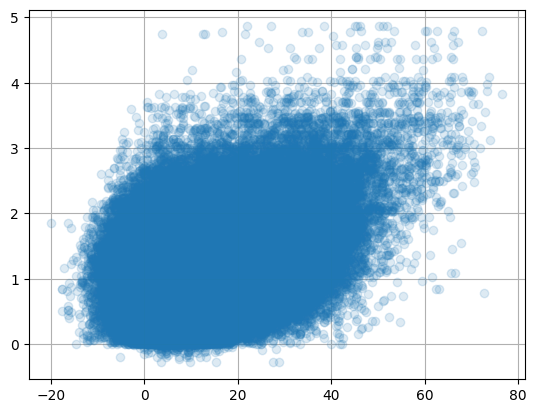

In [7]:
df1['trace_snr_db_z'] = df1.apply(lambda row: float(row['trace_snr_db'].split("|")[-1]), axis = 1)
plt.plot(df1['trace_snr_db_z'], df1['source_local_magnitude'].map(float) ,'o', alpha = 0.15);plt.grid(True)

In [8]:
list(df.keys())

['Unnamed: 0',
 'event_id',
 'source_origin_time',
 'source_latitude_deg',
 'source_longitude_deg',
 'source_type',
 'source_depth_km',
 'preferred_source_magnitude',
 'preferred_source_magnitude_type',
 'preferred_source_magnitude_uncertainty',
 'source_depth_uncertainty_km',
 'source_horizontal_uncertainty_km',
 'station_network_code',
 'station_channel_code',
 'station_code',
 'station_location_code',
 'station_latitude_deg',
 'station_longitude_deg',
 'station_elevation_m',
 'trace_name',
 'trace_sampling_rate_hz',
 'trace_start_time',
 'trace_S_arrival_sample',
 'trace_P_arrival_sample',
 'trace_S_arrival_uncertainty_s',
 'trace_P_arrival_uncertainty_s',
 'trace_P_polarity',
 'trace_S_onset',
 'trace_P_onset',
 'trace_snr_db',
 'year',
 'source_type_pnsn_label',
 'source_local_magnitude',
 'source_local_magnitude_uncertainty',
 'source_duration_magnitude',
 'source_duration_magnitude_uncertainty',
 'source_hand_magnitude']

In [9]:
f = h5py.File("miniPNW_waveforms.hdf5", "r")

In [10]:
def read_data(df, index, apply_filter = None, freq = None, freqmax = None, freqmin = None):
 
 
  # read metadata
    source_id = df.iloc[index]['event_id']
    net = df.iloc[index]['station_network_code']
    sta = df.iloc[index]['station_code']
    loc =  df.iloc[index]['station_location_code']
    cha = df.iloc[index]['station_channel_code']
    sample_p = df.iloc[index]['trace_P_arrival_sample']
    sample_s = df.iloc[index]['trace_S_arrival_sample']
    trace_starttime = df.iloc[index]['trace_start_time']
    sample_rate = df.iloc[index]['trace_sampling_rate_hz']

    # calculate distance
    slat,slon=df.iloc[index]['station_latitude_deg'],df.iloc[index]['station_longitude_deg']
    lat0,lon0=df.iloc[index]['source_latitude_deg'],df.iloc[index]['source_longitude_deg']
    dist,az,baz=gps2dist_azimuth(lat0,lon0,slat,slon)

 # read the data
    tn = df.iloc[index]['trace_name']
    bucket, narray = tn.split('$')
    x, y, z = iter([int(i) for i in narray.split(',:')])
    print(x,y,z)
    data = f['/data/%s' % bucket][x, :y, :z]

    stream = obspy.Stream()
    for i in range(3):
        tr = obspy.Trace()
        tr.data = data[i, :]
        tr.stats.sampling_rate = df.iloc[index]['trace_sampling_rate_hz']
        tr.stats.starttime= datetime.utcfromtimestamp(UTCDateTime(trace_starttime).timestamp)
        tr.stats.station=sta
        tr.stats.network=net
        tr.stats.location=loc
        if i==0:
          tr.stats.channel=cha+"E"
        elif i==1:
          tr.stats.channel=cha+"N"
        else :
          tr.stats.channel=cha+"Z"
        stream.append(tr)
    
    if apply_filter == 'bandpass':
        stream.filter(apply_filter, freqmin = freqmin, freqmax = freqmax)
    elif apply_filter is not None:
        stream.filter(apply_filter, freq = freq)

  # get phase pick / arrival time information

    starttime = datetime.utcfromtimestamp(UTCDateTime(trace_starttime).timestamp)
    x = [starttime + dt(seconds = i/sample_rate) for i in np.arange(15001)]
    p_time = sample_p/sample_rate 
    s_time = sample_s/sample_rate
    
    return stream, p_time,s_time,dist/1000

We will need to know the epicentral distance between each station and each receivers.

## Local magnitude

We can calculate local magnitude using obspy function ``estimate_magnitude``. 
The obspy function requires the data to be raw with its instrumental response, and the data has to remain in velocity.

We will use the PNSN definitions for calculating the Local Magnitude. The workflow is as follow:

1. Select North and East component seismograms.
2. Bandpass the data 0.2-50Hz.
3. Window the data using 5-min and 2 seconds before the P wave arrival time.
4. remove instrumental response of the seismometer, convert data to mm.
5. convolve the Wood-Anderson instrumental response. Note that the PNSN uses a modified gain for the response of 2080 instead of 2800 following Uhrhammer and Collins (1990).
6. take the maximum of the amplitude $A$ for each component and then its' log in base10: $log_{10}A$.
7. The PNSN takes the average of the two. We are going to take the maximum of the two, otherwise it is biased to be lower estimates.
8. The PNSN estimate the magnitude of the earthquake at each station $i$ as:
  * $M_L  = \sum_i \left[log_{10}A_i -  log_{10}A_0 (R_i)  + S_i\right]$

where $S_i$ is a station correction, $R_i$ is the epicentral distance between the earthquake and the station, and $log_{10}A_0 (R_i)$ is a function of distance to account for geometrical spreading an d attenuation as a function of distance.

Download the file from dropbox

In [11]:
wget.download("https://www.dropbox.com/s/edc0ygk0xhur4uj/a0.csv?dl=1")

100% [..............................................................] 562 / 562

'a0.csv'

read the CSV file: the first column is the epicentral distance, the second is the distance correction. Read the file and plot the two columns:

Text(0.5, 1.0, 'log(A0)')

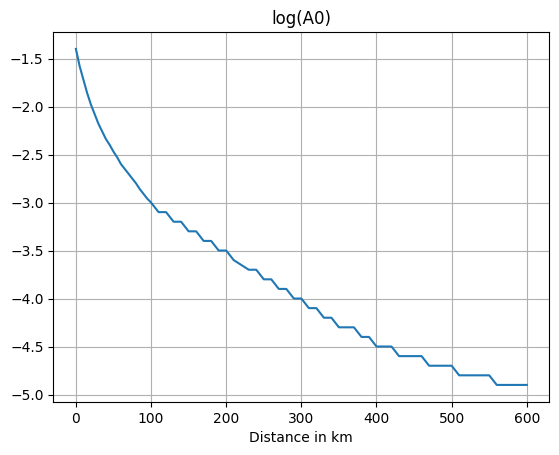

In [12]:
A0=pd.read_csv('a0.csv')
A0.describe()
plt.plot(A0['dist'],-A0['a0']);plt.grid(True);plt.xlabel('Distance in km');plt.title('log(A0)')

To get the local magnitude, we can manually remove the instrumental response and simulate the response of the Wood-Anderson instrument

In [13]:
paz_wood = {'sensitivity': 2080, 'zeros': [0j,0j], 'gain': 1,
          'poles': [-5.49779 + 5.60886j, -5.49779 -5.60886j]}

We need to get the station instrumental response. We will collect it using obspy and create an inventory for all unique stations in this data set.

['-1.444', '2.612', '9.921']
0
0 3 15001


/home/simonhans/anaconda3/envs/seismo/lib/python3.10/site-packages/obspy/core/inventory/response.py:1935: UserWarning: More than one PolesZerosResponseStage encountered. Returning first one found.
  warnings.warn(msg)
/home/simonhans/anaconda3/envs/seismo/lib/python3.10/site-packages/obspy/imaging/util.py:266: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small')
/home/simonhans/anaconda3/envs/seismo/lib/python3.10/site-packages/obspy/imaging/waveform.py:815: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small',


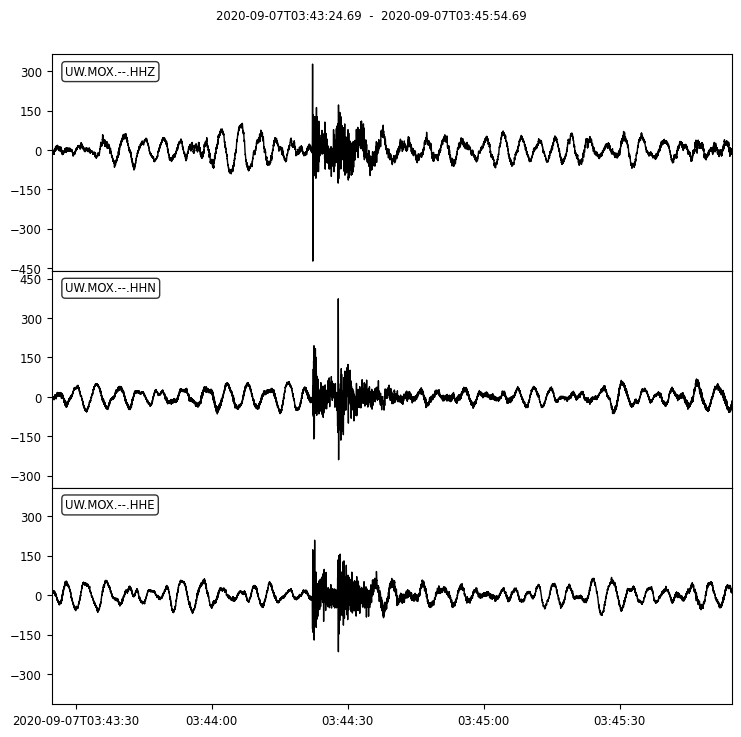

/home/simonhans/anaconda3/envs/seismo/lib/python3.10/site-packages/obspy/imaging/util.py:266: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small')
/home/simonhans/anaconda3/envs/seismo/lib/python3.10/site-packages/obspy/imaging/waveform.py:815: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small',


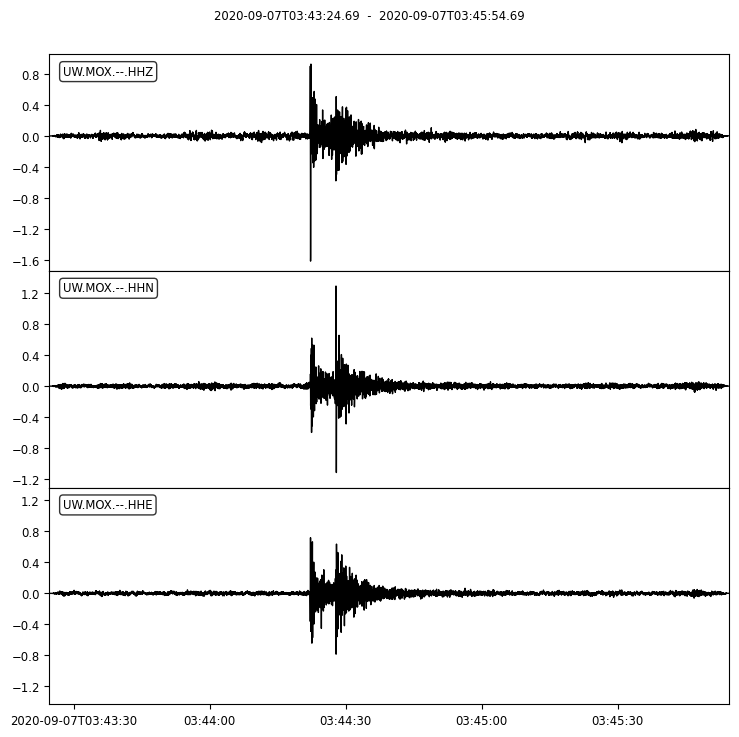

predicted magnitude 2.3560112286406167  correct magnitude 1.3
['0.368', '3.526', '5.981']
1
1 3 15001


/home/simonhans/anaconda3/envs/seismo/lib/python3.10/site-packages/obspy/imaging/util.py:266: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small')
/home/simonhans/anaconda3/envs/seismo/lib/python3.10/site-packages/obspy/imaging/waveform.py:815: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small',


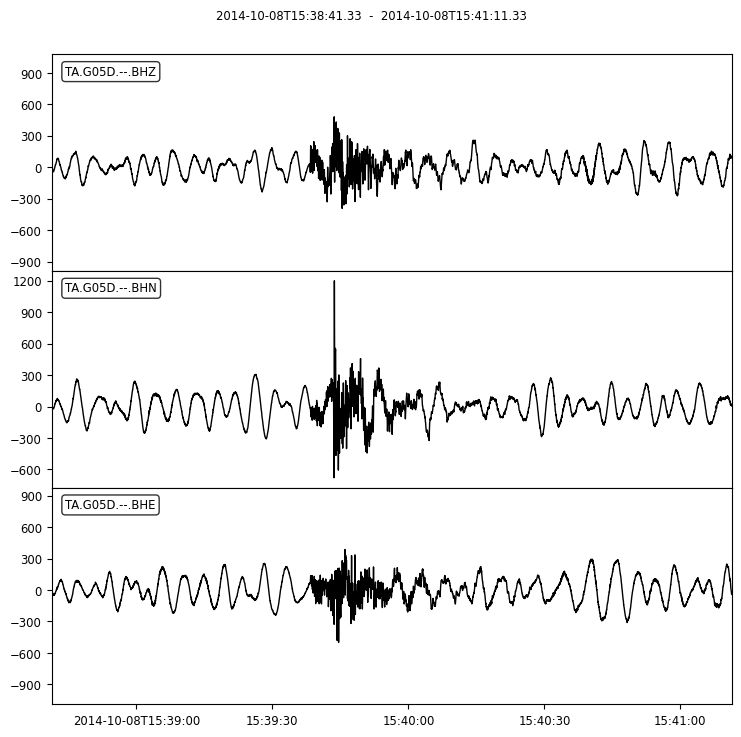

/home/simonhans/anaconda3/envs/seismo/lib/python3.10/site-packages/obspy/imaging/util.py:266: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small')
/home/simonhans/anaconda3/envs/seismo/lib/python3.10/site-packages/obspy/imaging/waveform.py:815: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small',


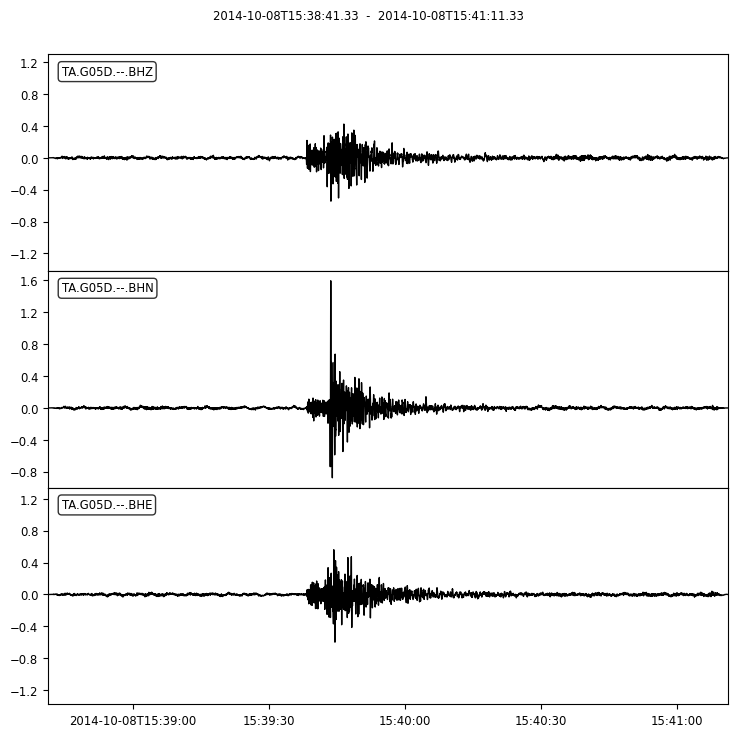

predicted magnitude 2.3001969918751652  correct magnitude 1.67
['11.274', '13.32', '15.828']
2
2 3 15001


/home/simonhans/anaconda3/envs/seismo/lib/python3.10/site-packages/obspy/core/inventory/response.py:1935: UserWarning: More than one PolesZerosResponseStage encountered. Returning first one found.
  warnings.warn(msg)
/home/simonhans/anaconda3/envs/seismo/lib/python3.10/site-packages/obspy/imaging/util.py:266: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small')
/home/simonhans/anaconda3/envs/seismo/lib/python3.10/site-packages/obspy/imaging/waveform.py:815: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small',


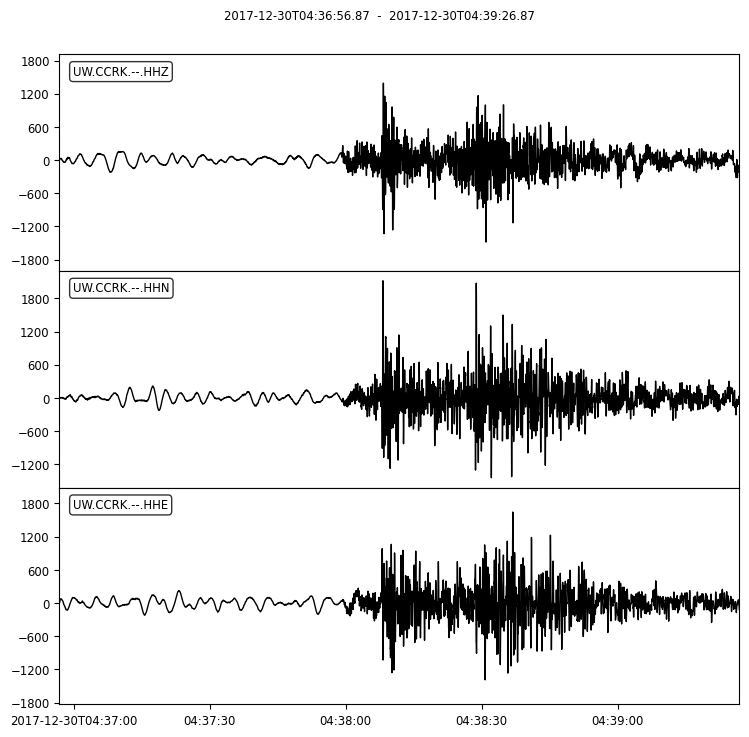

/home/simonhans/anaconda3/envs/seismo/lib/python3.10/site-packages/obspy/imaging/util.py:266: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small')
/home/simonhans/anaconda3/envs/seismo/lib/python3.10/site-packages/obspy/imaging/waveform.py:815: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small',


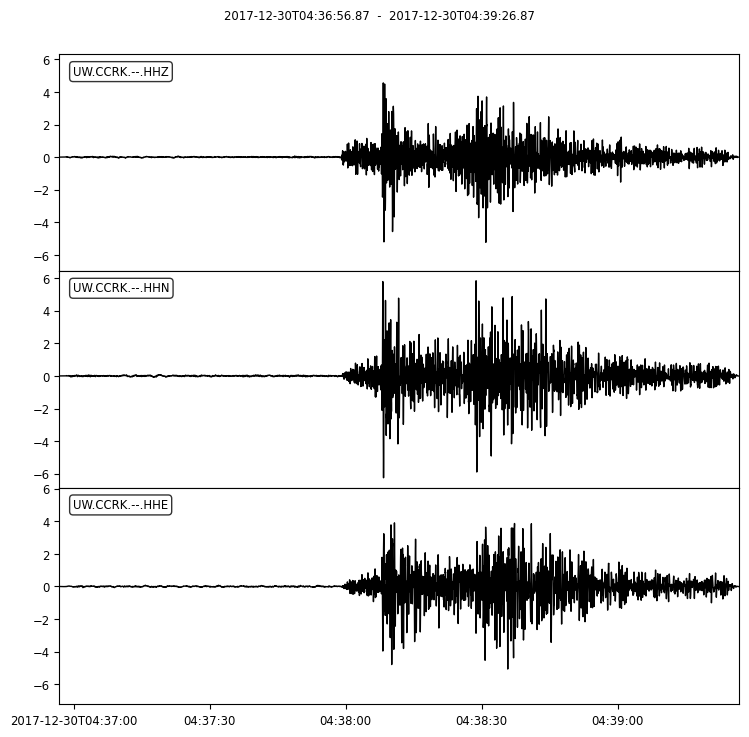

predicted magnitude 3.4526132311872137  correct magnitude 2.46
['27.007', '20.797', '19.252']
3
3 3 15001


/home/simonhans/anaconda3/envs/seismo/lib/python3.10/site-packages/obspy/core/inventory/response.py:1935: UserWarning: More than one PolesZerosResponseStage encountered. Returning first one found.
  warnings.warn(msg)
/home/simonhans/anaconda3/envs/seismo/lib/python3.10/site-packages/obspy/imaging/util.py:266: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small')
/home/simonhans/anaconda3/envs/seismo/lib/python3.10/site-packages/obspy/imaging/waveform.py:815: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small',


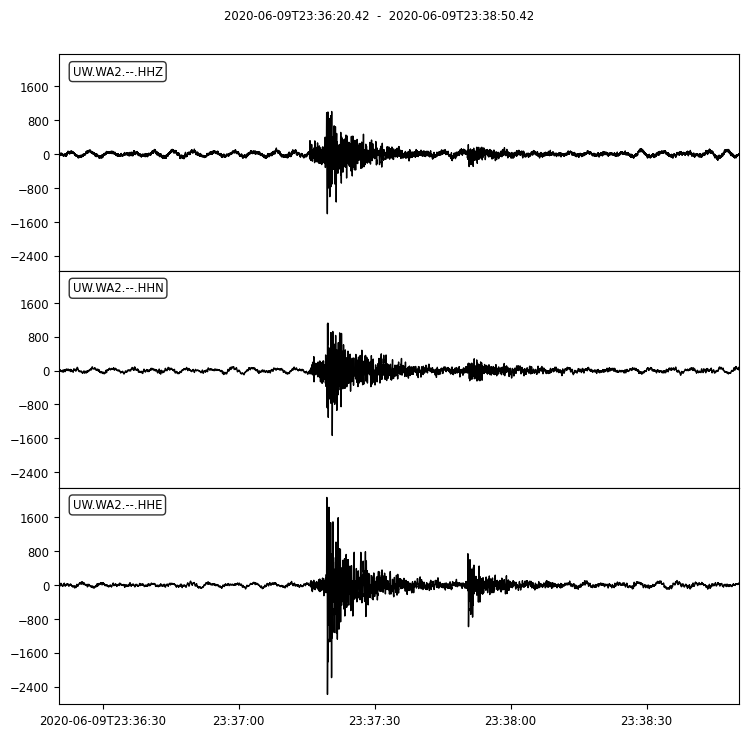

/home/simonhans/anaconda3/envs/seismo/lib/python3.10/site-packages/obspy/imaging/util.py:266: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small')
/home/simonhans/anaconda3/envs/seismo/lib/python3.10/site-packages/obspy/imaging/waveform.py:815: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small',


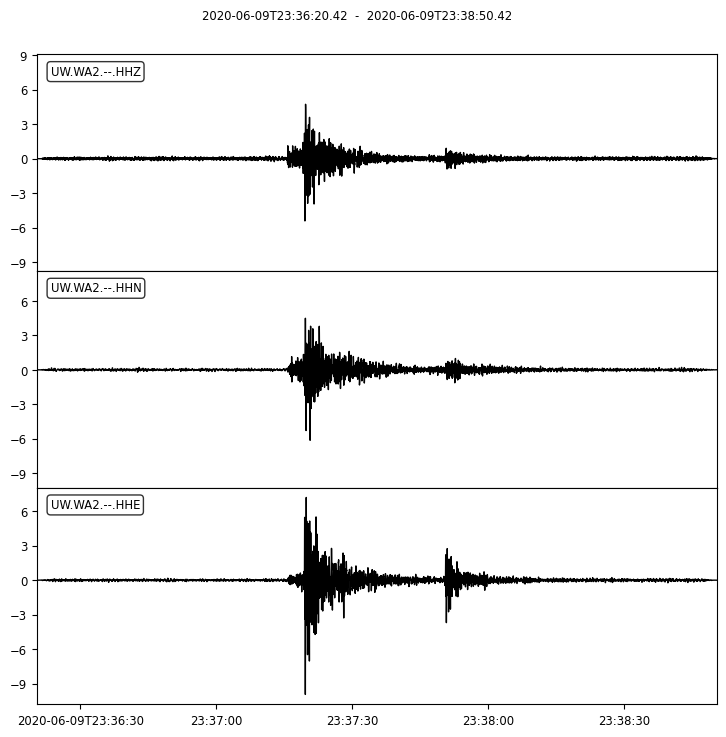

predicted magnitude 2.985224338114405  correct magnitude 1.59
['18.579', '18.912', '7.609']
4
4 3 15001


/home/simonhans/anaconda3/envs/seismo/lib/python3.10/site-packages/obspy/core/inventory/response.py:1935: UserWarning: More than one PolesZerosResponseStage encountered. Returning first one found.
  warnings.warn(msg)
/home/simonhans/anaconda3/envs/seismo/lib/python3.10/site-packages/obspy/imaging/util.py:266: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small')
/home/simonhans/anaconda3/envs/seismo/lib/python3.10/site-packages/obspy/imaging/waveform.py:815: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small',


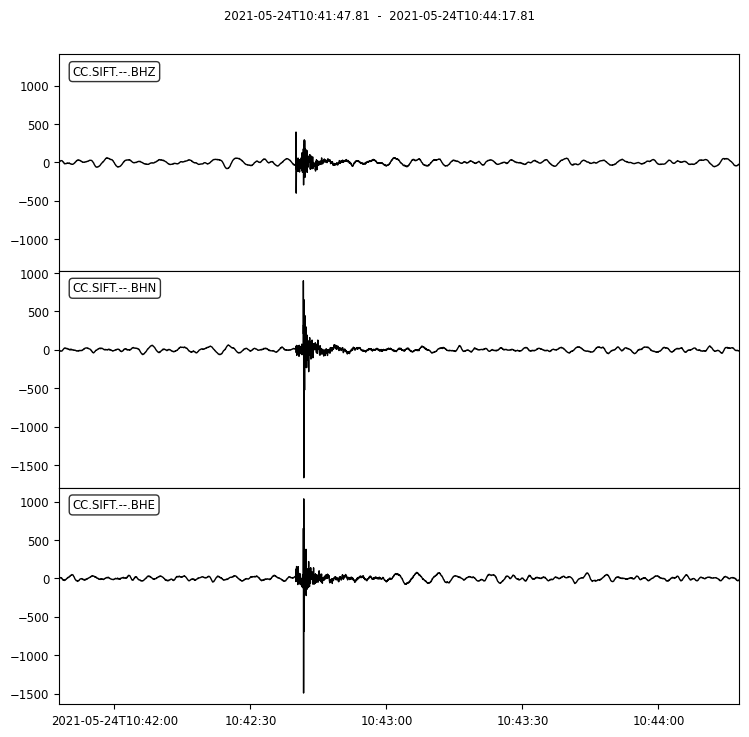

/home/simonhans/anaconda3/envs/seismo/lib/python3.10/site-packages/obspy/imaging/util.py:266: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small')
/home/simonhans/anaconda3/envs/seismo/lib/python3.10/site-packages/obspy/imaging/waveform.py:815: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small',


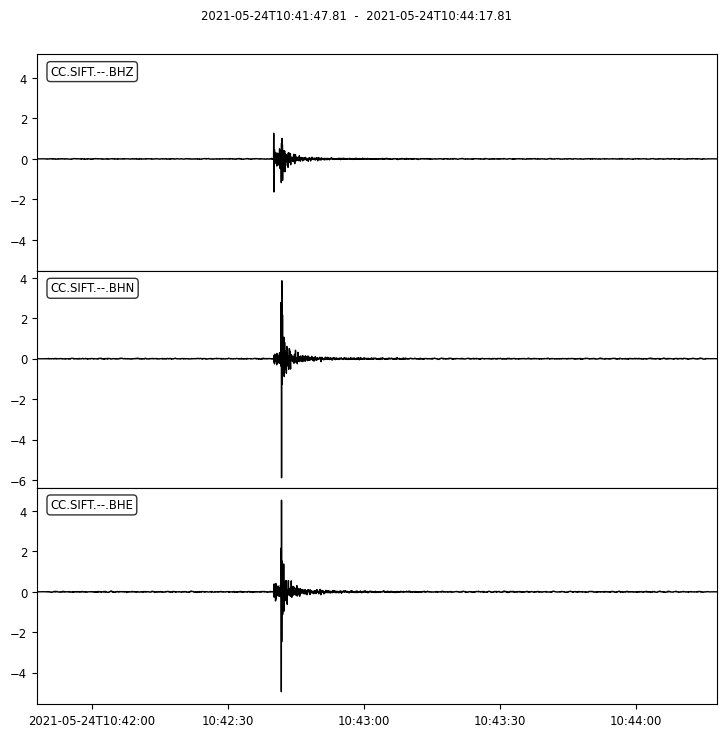

predicted magnitude 2.1332706856909  correct magnitude 0.83
['3.979', '2.314', '3.858']
5
5 3 15001


/home/simonhans/anaconda3/envs/seismo/lib/python3.10/site-packages/obspy/core/inventory/response.py:1935: UserWarning: More than one PolesZerosResponseStage encountered. Returning first one found.
  warnings.warn(msg)
/home/simonhans/anaconda3/envs/seismo/lib/python3.10/site-packages/obspy/imaging/util.py:266: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small')
/home/simonhans/anaconda3/envs/seismo/lib/python3.10/site-packages/obspy/imaging/waveform.py:815: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small',


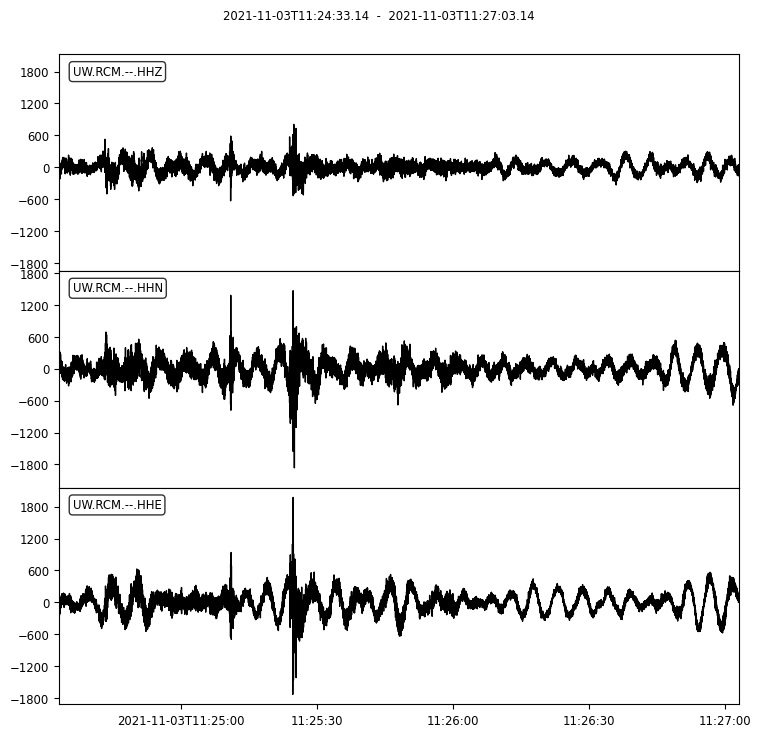

/home/simonhans/anaconda3/envs/seismo/lib/python3.10/site-packages/obspy/imaging/util.py:266: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small')
/home/simonhans/anaconda3/envs/seismo/lib/python3.10/site-packages/obspy/imaging/waveform.py:815: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small',


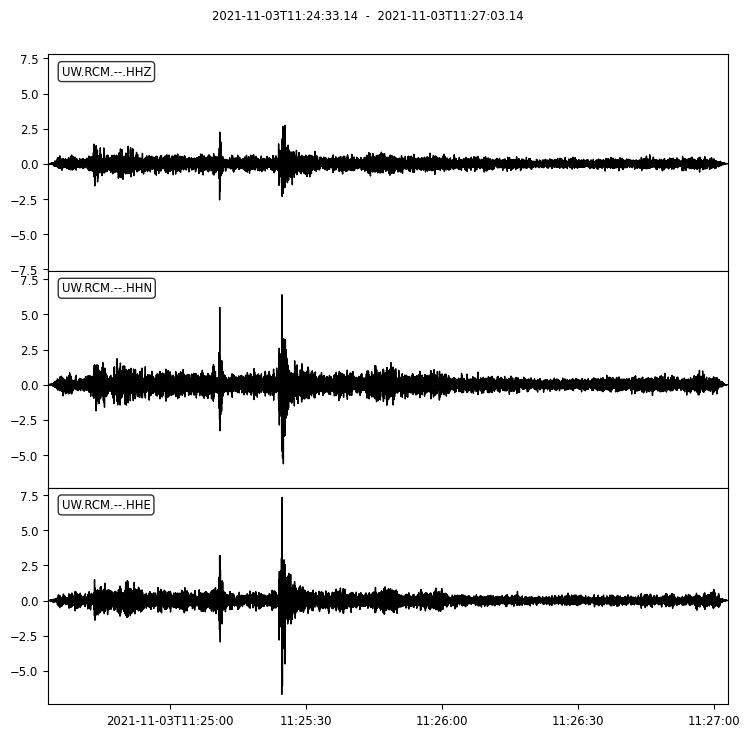

predicted magnitude 2.4171227934334487  correct magnitude 0.78
['13.849', '16.107', '13.35']
6
6 3 15001


/home/simonhans/anaconda3/envs/seismo/lib/python3.10/site-packages/obspy/imaging/util.py:266: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small')
/home/simonhans/anaconda3/envs/seismo/lib/python3.10/site-packages/obspy/imaging/waveform.py:815: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small',


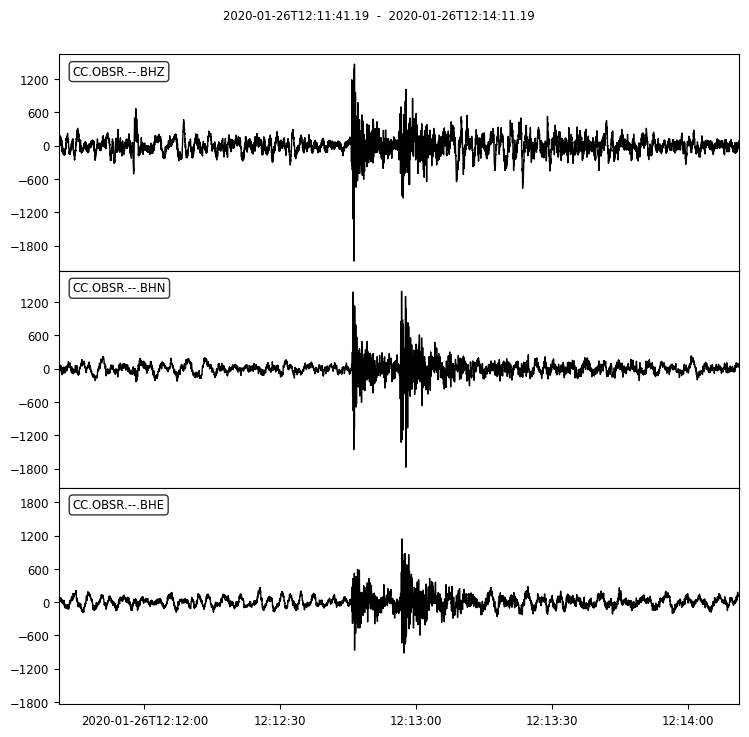

/home/simonhans/anaconda3/envs/seismo/lib/python3.10/site-packages/obspy/imaging/util.py:266: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small')
/home/simonhans/anaconda3/envs/seismo/lib/python3.10/site-packages/obspy/imaging/waveform.py:815: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small',


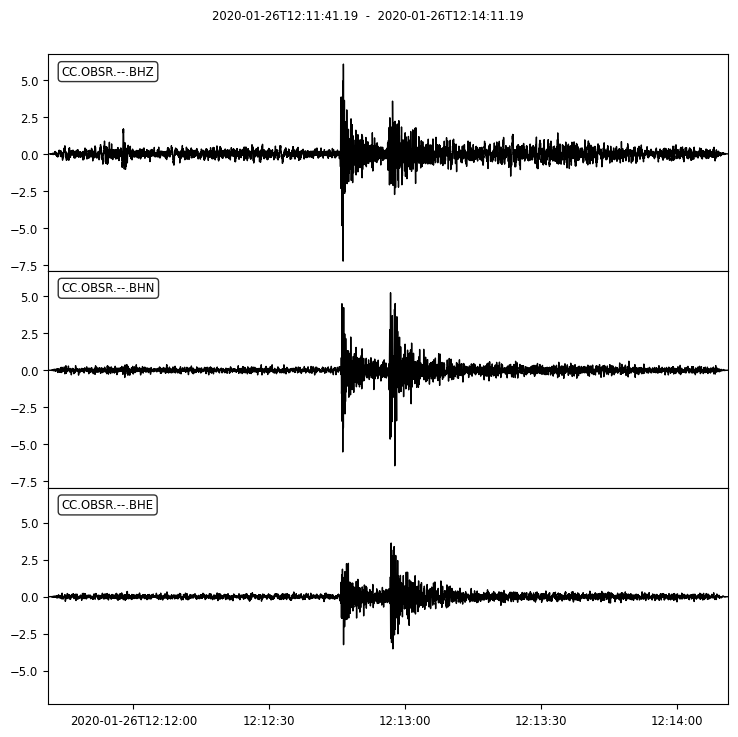

predicted magnitude 3.612195508148712  correct magnitude 2.02
['9.664', '17.310', '19.197']
7
7 3 15001


/home/simonhans/anaconda3/envs/seismo/lib/python3.10/site-packages/obspy/imaging/util.py:266: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small')
/home/simonhans/anaconda3/envs/seismo/lib/python3.10/site-packages/obspy/imaging/waveform.py:815: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small',


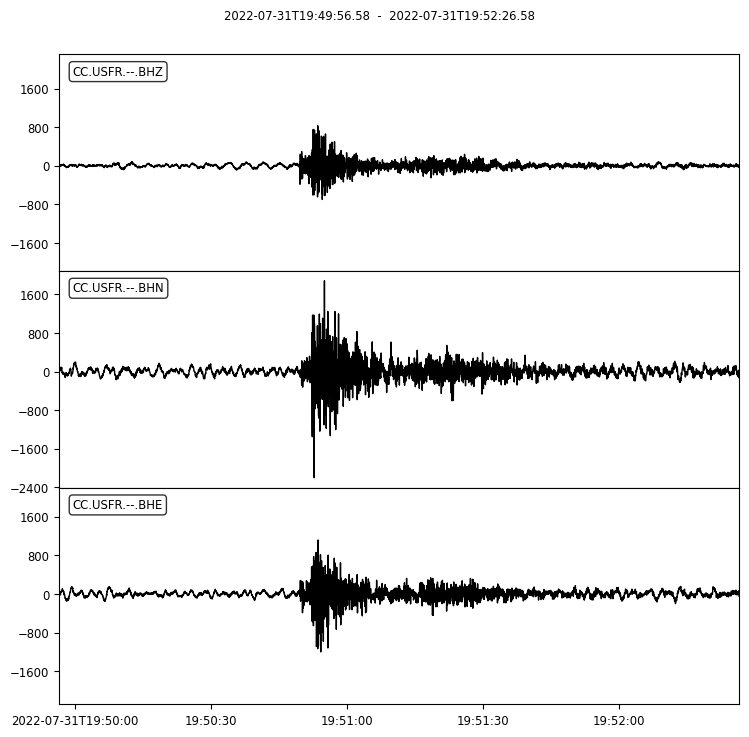

/home/simonhans/anaconda3/envs/seismo/lib/python3.10/site-packages/obspy/imaging/util.py:266: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small')
/home/simonhans/anaconda3/envs/seismo/lib/python3.10/site-packages/obspy/imaging/waveform.py:815: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small',


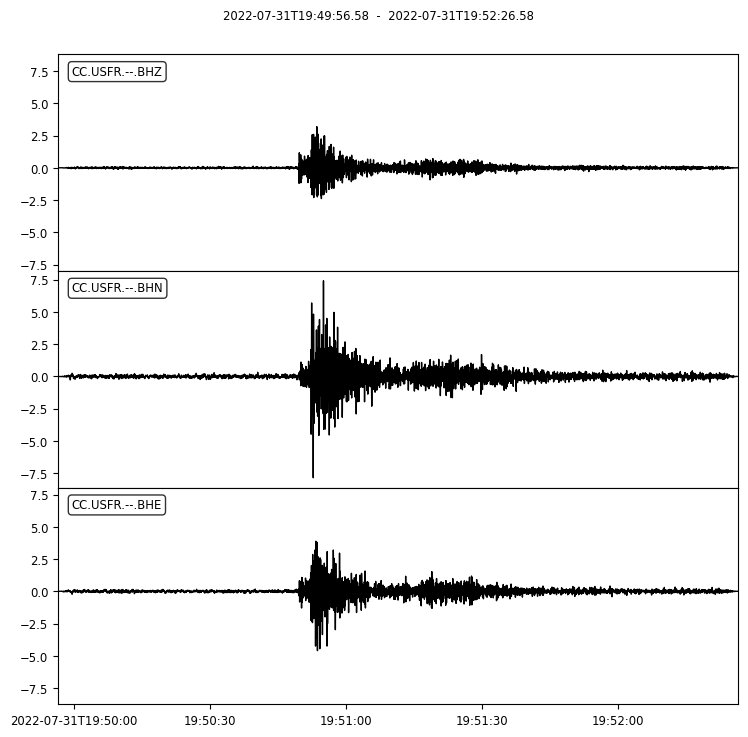

predicted magnitude 2.653951309069142  correct magnitude 1.09
['-0.255', '0.870', '4.329']
8
8 3 15001


/home/simonhans/anaconda3/envs/seismo/lib/python3.10/site-packages/obspy/core/inventory/response.py:1935: UserWarning: More than one PolesZerosResponseStage encountered. Returning first one found.
  warnings.warn(msg)
/home/simonhans/anaconda3/envs/seismo/lib/python3.10/site-packages/obspy/imaging/util.py:266: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small')
/home/simonhans/anaconda3/envs/seismo/lib/python3.10/site-packages/obspy/imaging/waveform.py:815: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small',


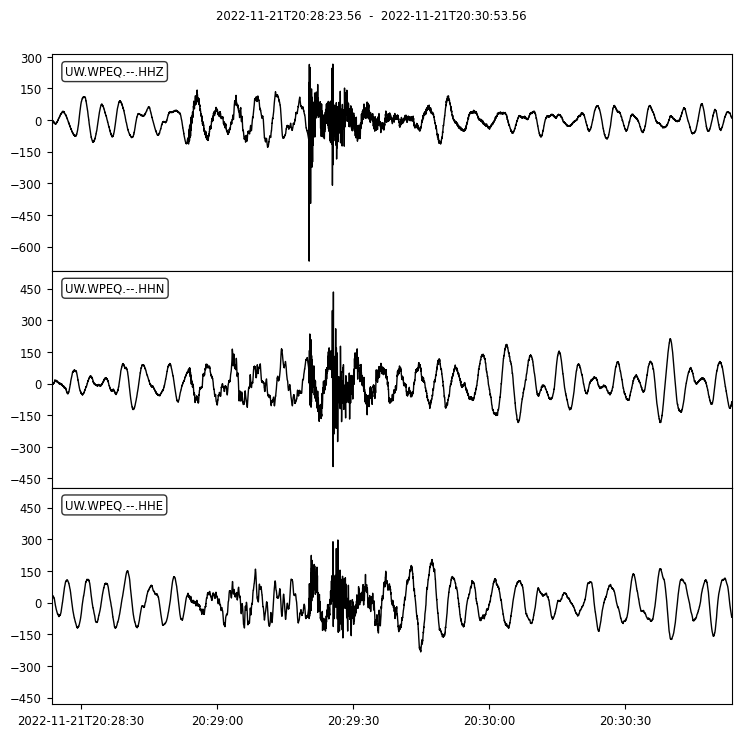

/home/simonhans/anaconda3/envs/seismo/lib/python3.10/site-packages/obspy/imaging/util.py:266: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small')
/home/simonhans/anaconda3/envs/seismo/lib/python3.10/site-packages/obspy/imaging/waveform.py:815: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small',


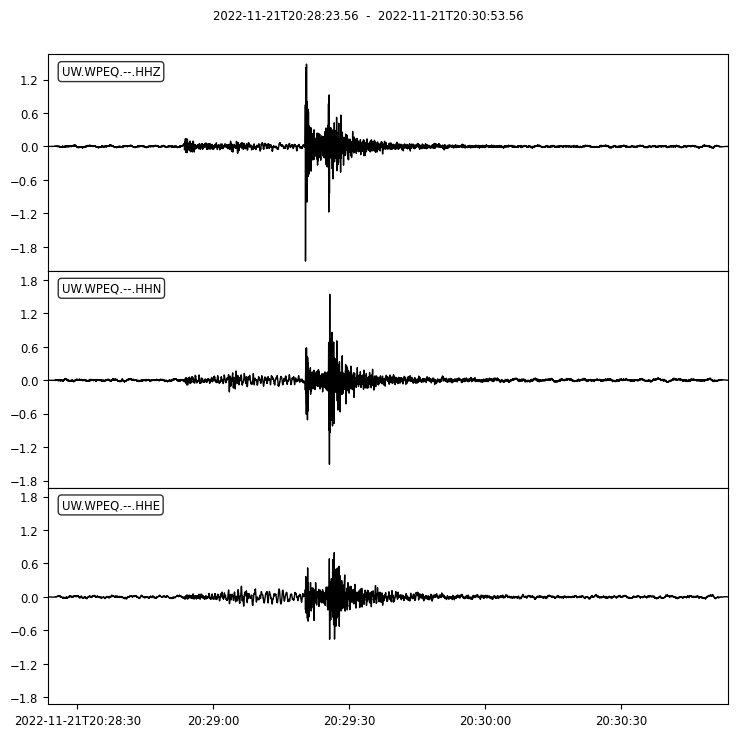

predicted magnitude 2.327423877987785  correct magnitude 1.55
['-2.507', '1.673', '-4.718']
9
9 3 15001


/home/simonhans/anaconda3/envs/seismo/lib/python3.10/site-packages/obspy/core/inventory/response.py:1935: UserWarning: More than one PolesZerosResponseStage encountered. Returning first one found.
  warnings.warn(msg)
/home/simonhans/anaconda3/envs/seismo/lib/python3.10/site-packages/obspy/imaging/util.py:266: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small')
/home/simonhans/anaconda3/envs/seismo/lib/python3.10/site-packages/obspy/imaging/waveform.py:815: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small',


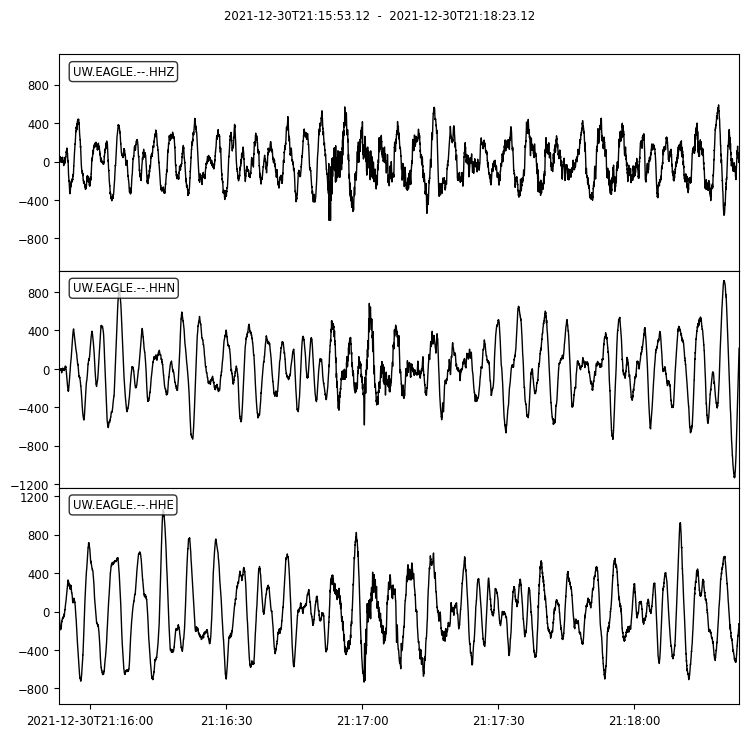

/home/simonhans/anaconda3/envs/seismo/lib/python3.10/site-packages/obspy/imaging/util.py:266: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small')
/home/simonhans/anaconda3/envs/seismo/lib/python3.10/site-packages/obspy/imaging/waveform.py:815: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small',


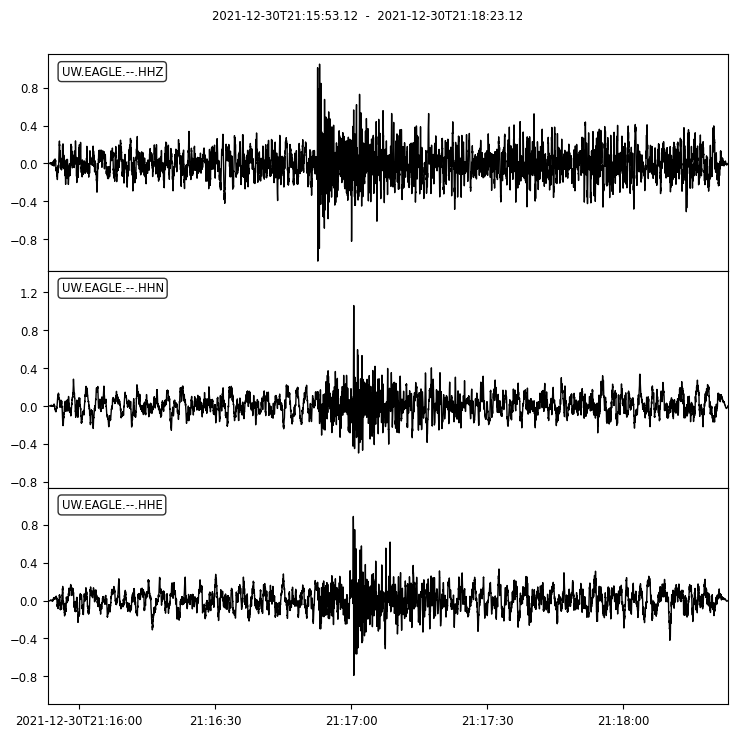

predicted magnitude 2.3276933768320935  correct magnitude 1.64
['17.312', '28.695', '20.688']
10
10 3 15001


/home/simonhans/anaconda3/envs/seismo/lib/python3.10/site-packages/obspy/imaging/util.py:266: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small')
/home/simonhans/anaconda3/envs/seismo/lib/python3.10/site-packages/obspy/imaging/waveform.py:815: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small',


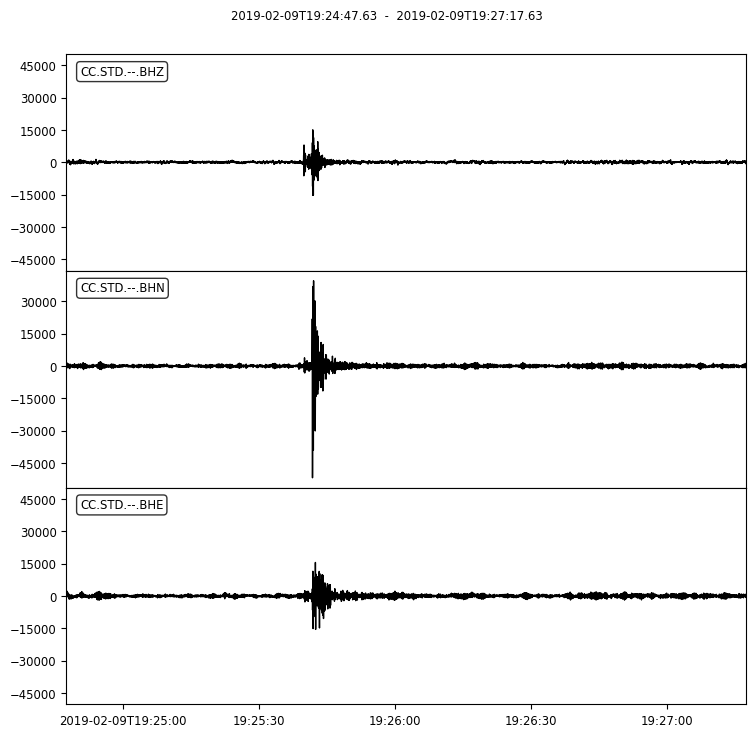

/home/simonhans/anaconda3/envs/seismo/lib/python3.10/site-packages/obspy/imaging/util.py:266: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small')
/home/simonhans/anaconda3/envs/seismo/lib/python3.10/site-packages/obspy/imaging/waveform.py:815: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small',


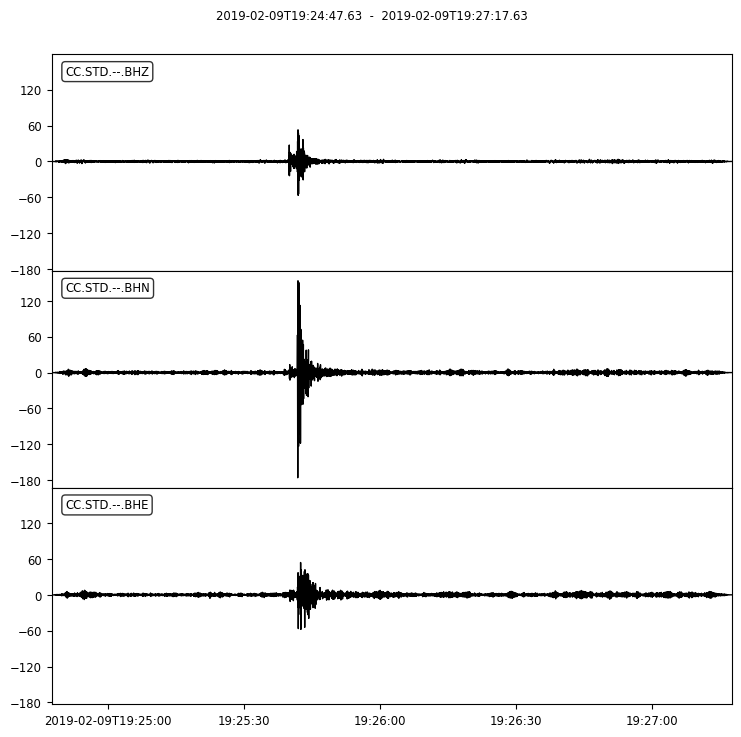

predicted magnitude 3.7875562144530255  correct magnitude 1.88
['10.895', '9.58', '7.348']
11
11 3 15001


/home/simonhans/anaconda3/envs/seismo/lib/python3.10/site-packages/obspy/imaging/util.py:266: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small')
/home/simonhans/anaconda3/envs/seismo/lib/python3.10/site-packages/obspy/imaging/waveform.py:815: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small',


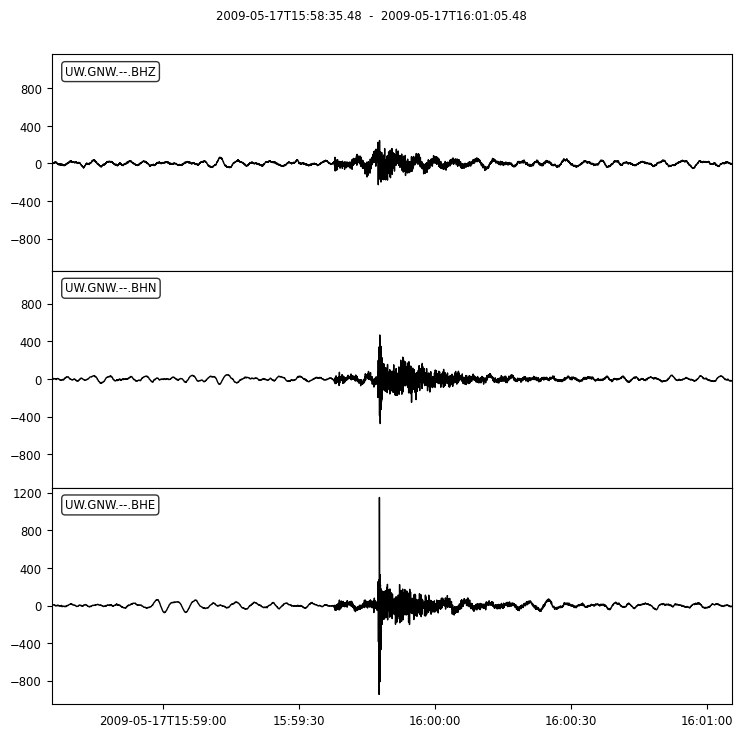

/home/simonhans/anaconda3/envs/seismo/lib/python3.10/site-packages/obspy/imaging/util.py:266: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small')
/home/simonhans/anaconda3/envs/seismo/lib/python3.10/site-packages/obspy/imaging/waveform.py:815: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small',


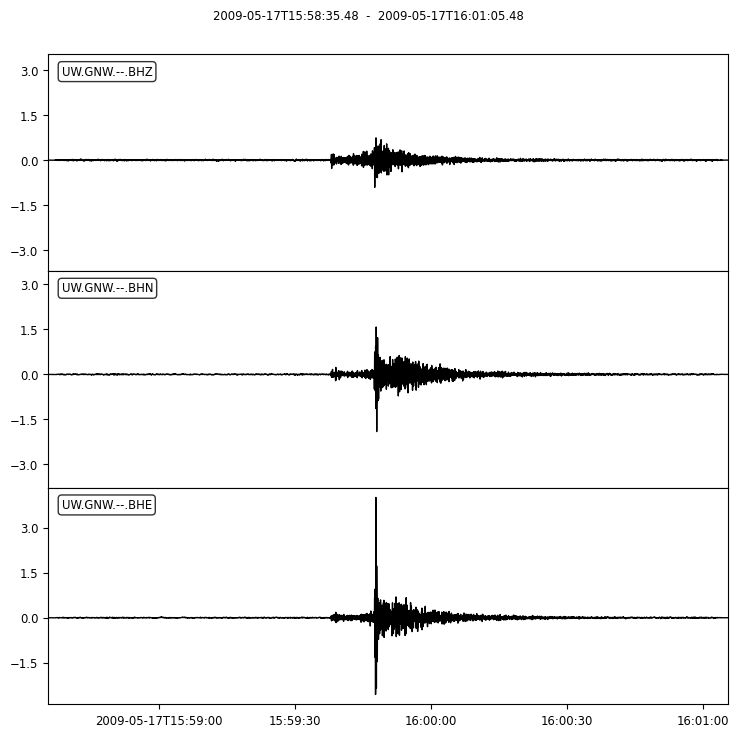

predicted magnitude 3.2710883821652703  correct magnitude 2.14
['32.619', '27.979', '19.629']
12
12 3 15001


/home/simonhans/anaconda3/envs/seismo/lib/python3.10/site-packages/obspy/core/inventory/response.py:1935: UserWarning: More than one PolesZerosResponseStage encountered. Returning first one found.
  warnings.warn(msg)
/home/simonhans/anaconda3/envs/seismo/lib/python3.10/site-packages/obspy/imaging/util.py:266: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small')
/home/simonhans/anaconda3/envs/seismo/lib/python3.10/site-packages/obspy/imaging/waveform.py:815: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small',


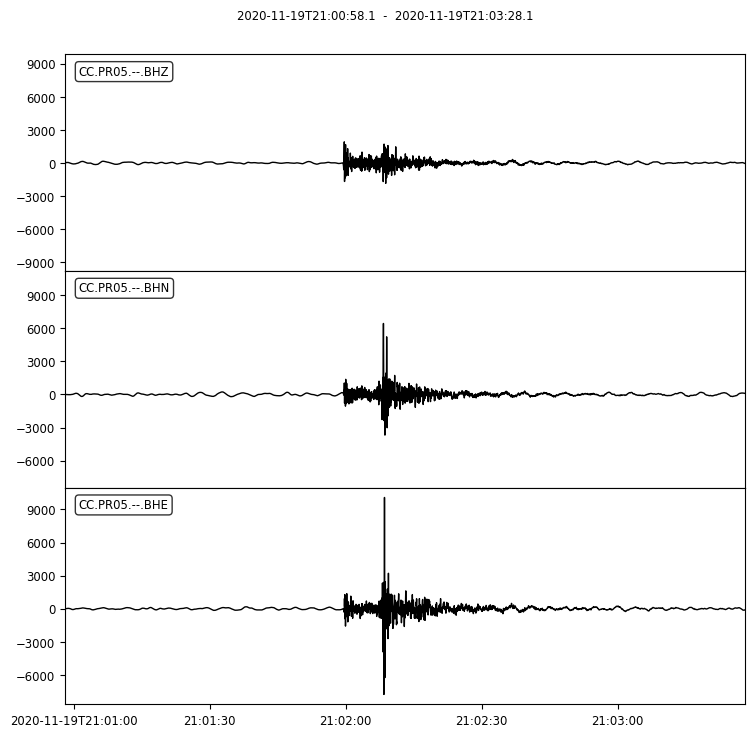

/home/simonhans/anaconda3/envs/seismo/lib/python3.10/site-packages/obspy/imaging/util.py:266: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small')
/home/simonhans/anaconda3/envs/seismo/lib/python3.10/site-packages/obspy/imaging/waveform.py:815: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small',


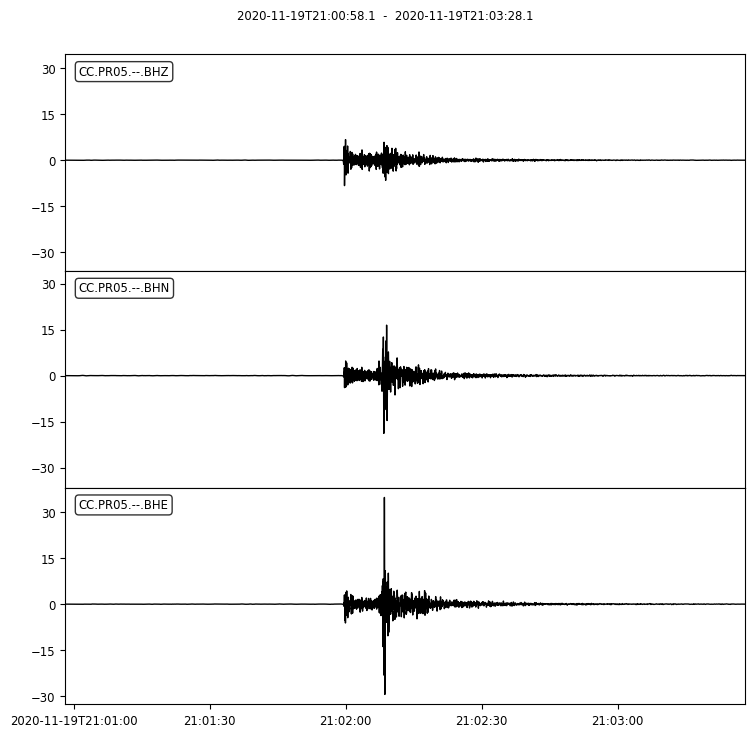

predicted magnitude 4.07800558777164  correct magnitude 2.87
['1.65', '-4.833', '0.659']
13
13 3 15001


/home/simonhans/anaconda3/envs/seismo/lib/python3.10/site-packages/obspy/core/inventory/response.py:1935: UserWarning: More than one PolesZerosResponseStage encountered. Returning first one found.
  warnings.warn(msg)
/home/simonhans/anaconda3/envs/seismo/lib/python3.10/site-packages/obspy/imaging/util.py:266: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small')
/home/simonhans/anaconda3/envs/seismo/lib/python3.10/site-packages/obspy/imaging/waveform.py:815: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small',


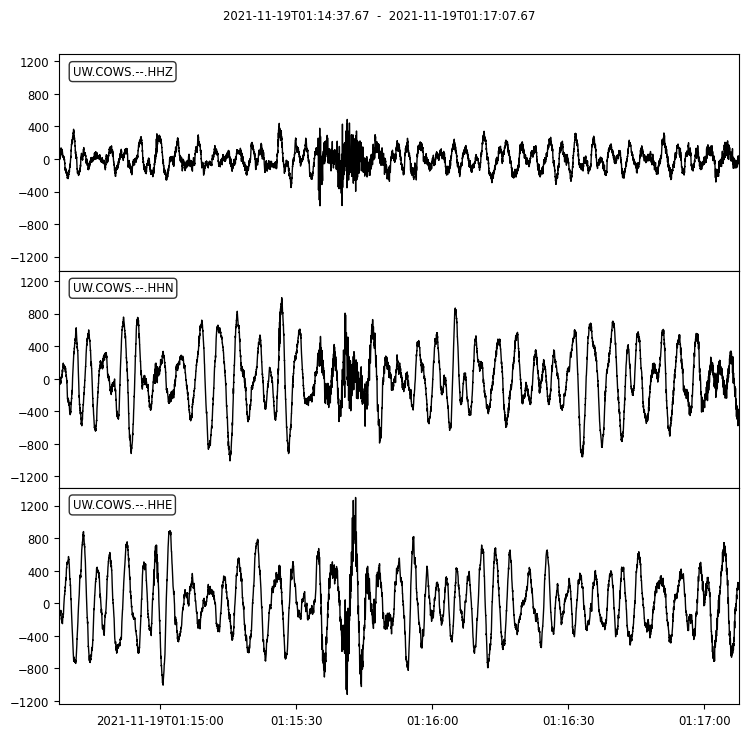

/home/simonhans/anaconda3/envs/seismo/lib/python3.10/site-packages/obspy/imaging/util.py:266: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small')
/home/simonhans/anaconda3/envs/seismo/lib/python3.10/site-packages/obspy/imaging/waveform.py:815: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small',


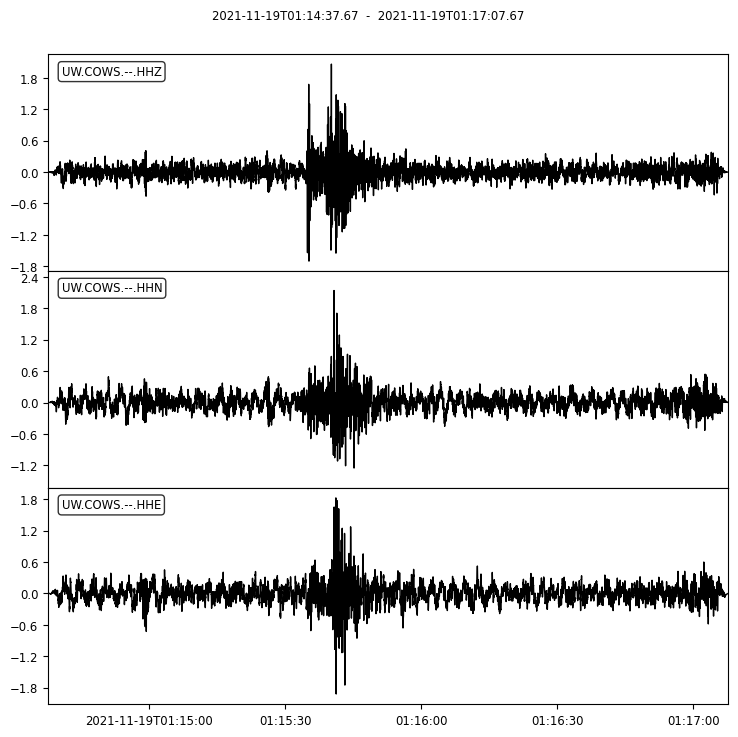

predicted magnitude 2.567543825453816  correct magnitude 1.47
['2.0', '11.96', '5.55']
14
14 3 15001


/home/simonhans/anaconda3/envs/seismo/lib/python3.10/site-packages/obspy/imaging/util.py:266: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small')
/home/simonhans/anaconda3/envs/seismo/lib/python3.10/site-packages/obspy/imaging/waveform.py:815: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small',


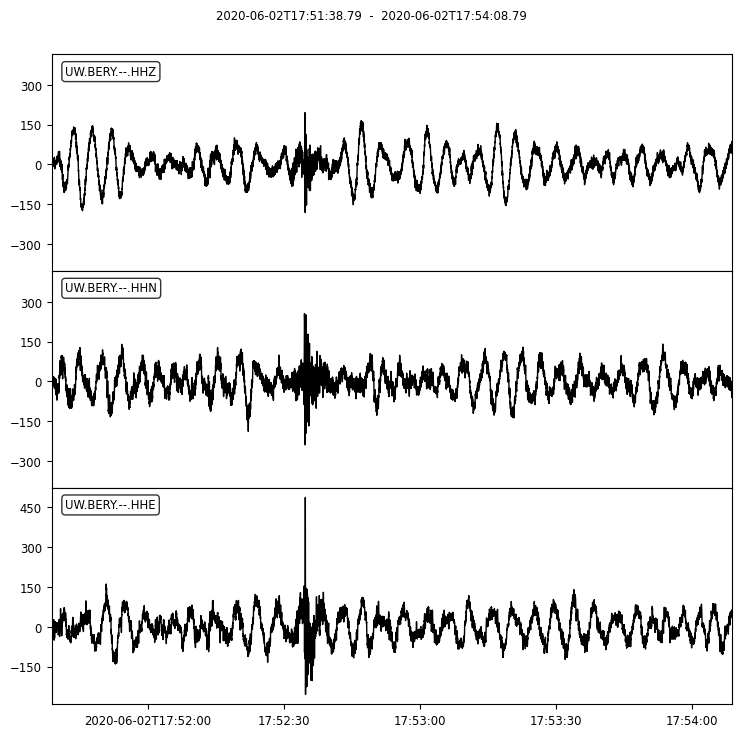

/home/simonhans/anaconda3/envs/seismo/lib/python3.10/site-packages/obspy/imaging/util.py:266: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small')
/home/simonhans/anaconda3/envs/seismo/lib/python3.10/site-packages/obspy/imaging/waveform.py:815: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small',


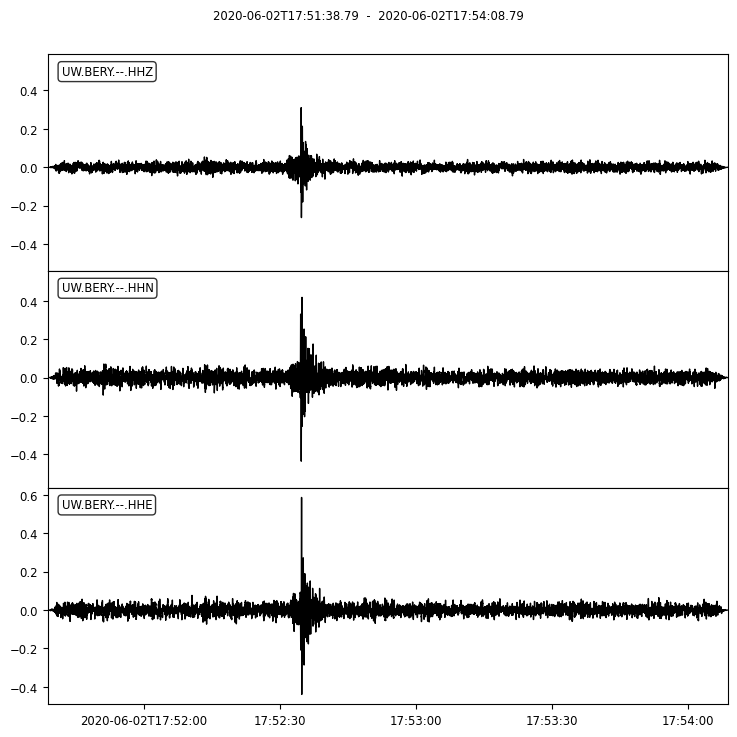

predicted magnitude 1.5684538640089467  correct magnitude 0.6
['12.637', '9.155', '10.326']
15
15 3 15001


/home/simonhans/anaconda3/envs/seismo/lib/python3.10/site-packages/obspy/imaging/util.py:266: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small')
/home/simonhans/anaconda3/envs/seismo/lib/python3.10/site-packages/obspy/imaging/waveform.py:815: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small',


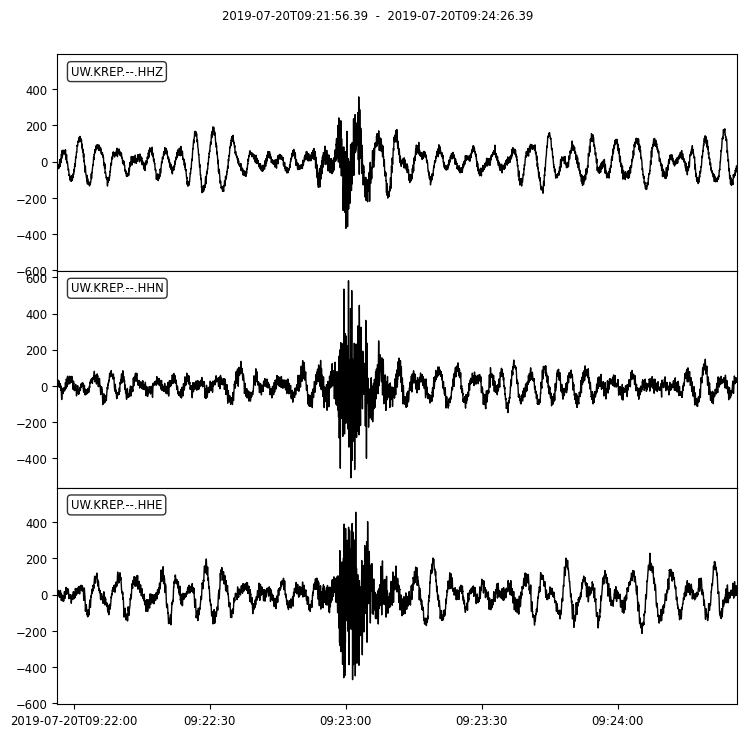

/home/simonhans/anaconda3/envs/seismo/lib/python3.10/site-packages/obspy/imaging/util.py:266: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small')
/home/simonhans/anaconda3/envs/seismo/lib/python3.10/site-packages/obspy/imaging/waveform.py:815: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small',


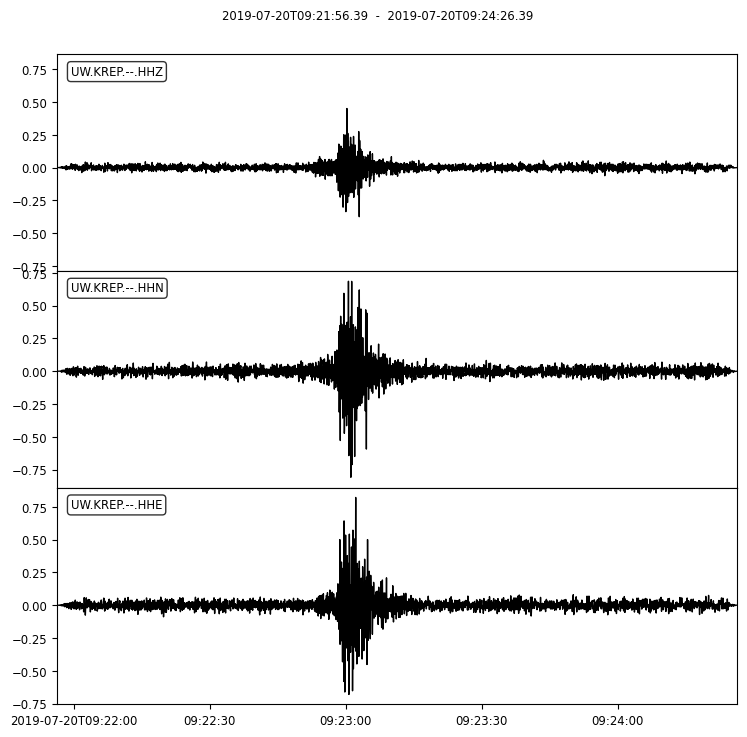

predicted magnitude 2.2512118317061582  correct magnitude 1.02
['32.299', '32.991', '22.968']
16
16 3 15001


/home/simonhans/anaconda3/envs/seismo/lib/python3.10/site-packages/obspy/imaging/util.py:266: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small')
/home/simonhans/anaconda3/envs/seismo/lib/python3.10/site-packages/obspy/imaging/waveform.py:815: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small',


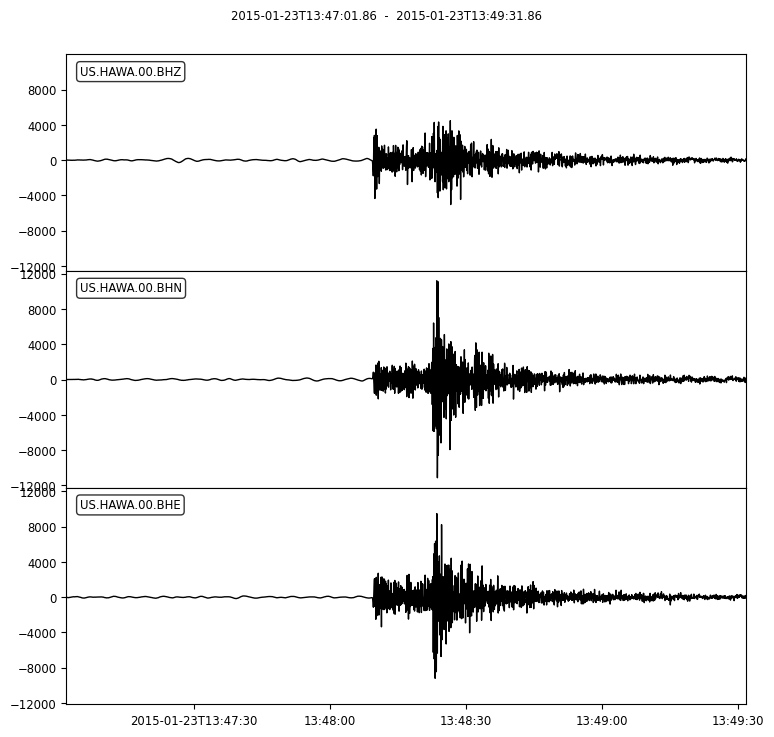

/home/simonhans/anaconda3/envs/seismo/lib/python3.10/site-packages/obspy/imaging/util.py:266: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small')
/home/simonhans/anaconda3/envs/seismo/lib/python3.10/site-packages/obspy/imaging/waveform.py:815: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small',


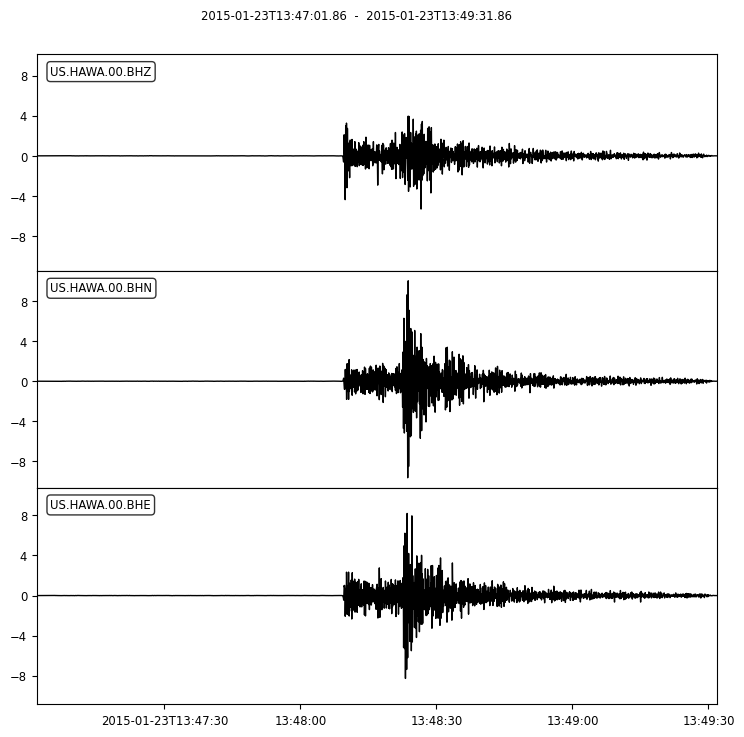

predicted magnitude 4.061344076035469  correct magnitude 3.72
['1.058', '2.934', '9.869']
17
17 3 15001


/home/simonhans/anaconda3/envs/seismo/lib/python3.10/site-packages/obspy/imaging/util.py:266: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small')
/home/simonhans/anaconda3/envs/seismo/lib/python3.10/site-packages/obspy/imaging/waveform.py:815: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small',


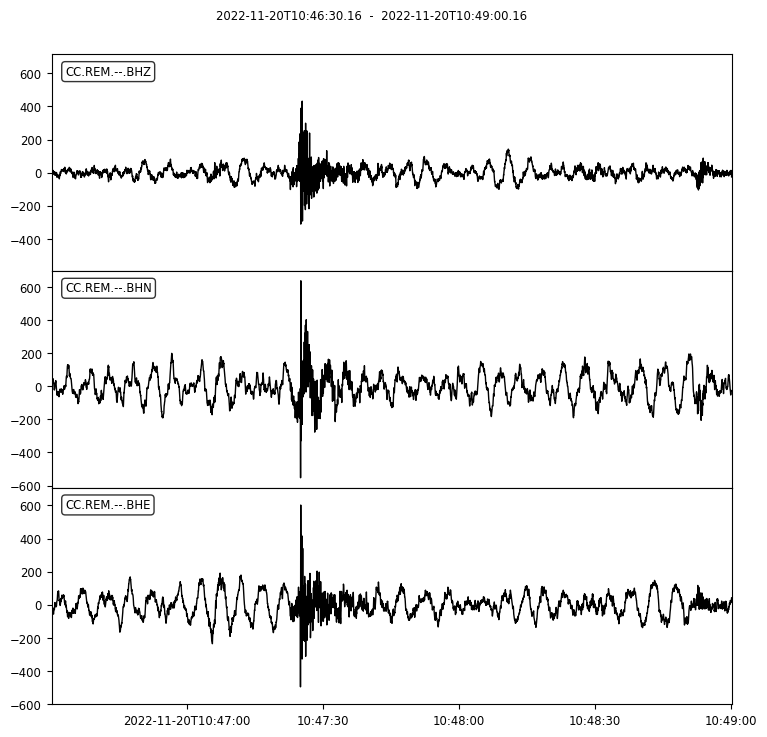

/home/simonhans/anaconda3/envs/seismo/lib/python3.10/site-packages/obspy/imaging/util.py:266: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small')
/home/simonhans/anaconda3/envs/seismo/lib/python3.10/site-packages/obspy/imaging/waveform.py:815: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small',


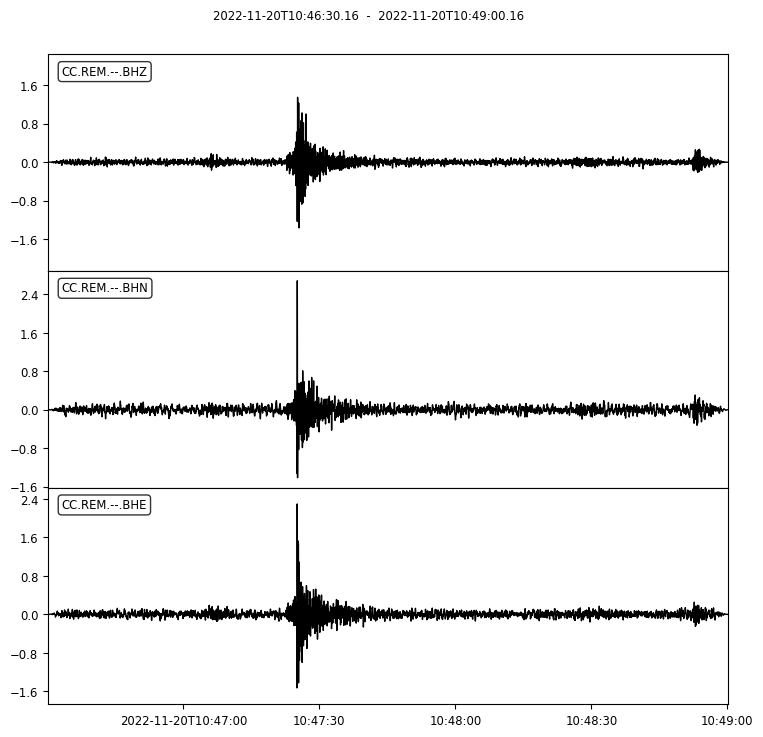

predicted magnitude 2.115784582404268  correct magnitude 0.4
['20.819', '20.843', '14.261']
18
18 3 15001


/home/simonhans/anaconda3/envs/seismo/lib/python3.10/site-packages/obspy/imaging/util.py:266: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small')
/home/simonhans/anaconda3/envs/seismo/lib/python3.10/site-packages/obspy/imaging/waveform.py:815: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small',


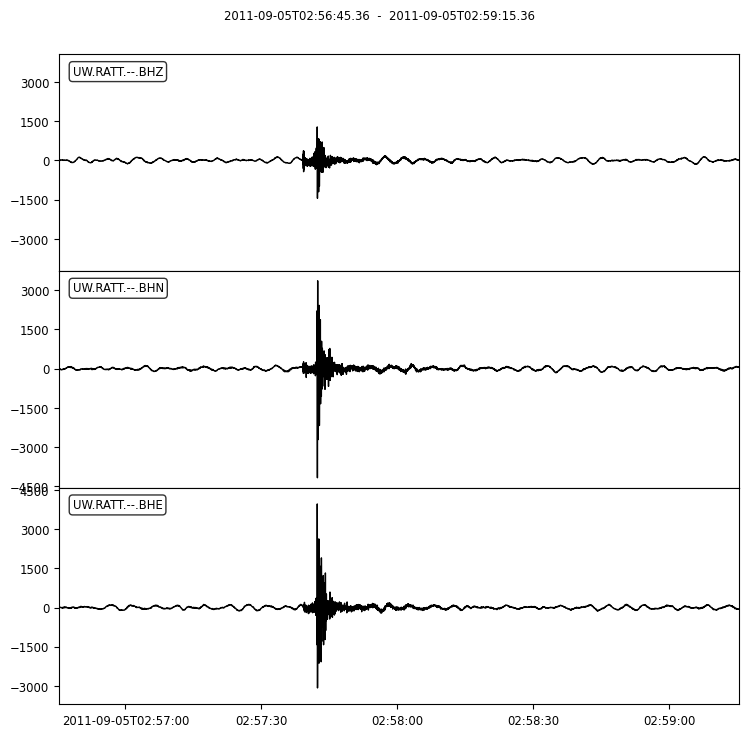

/home/simonhans/anaconda3/envs/seismo/lib/python3.10/site-packages/obspy/imaging/util.py:266: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small')
/home/simonhans/anaconda3/envs/seismo/lib/python3.10/site-packages/obspy/imaging/waveform.py:815: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small',


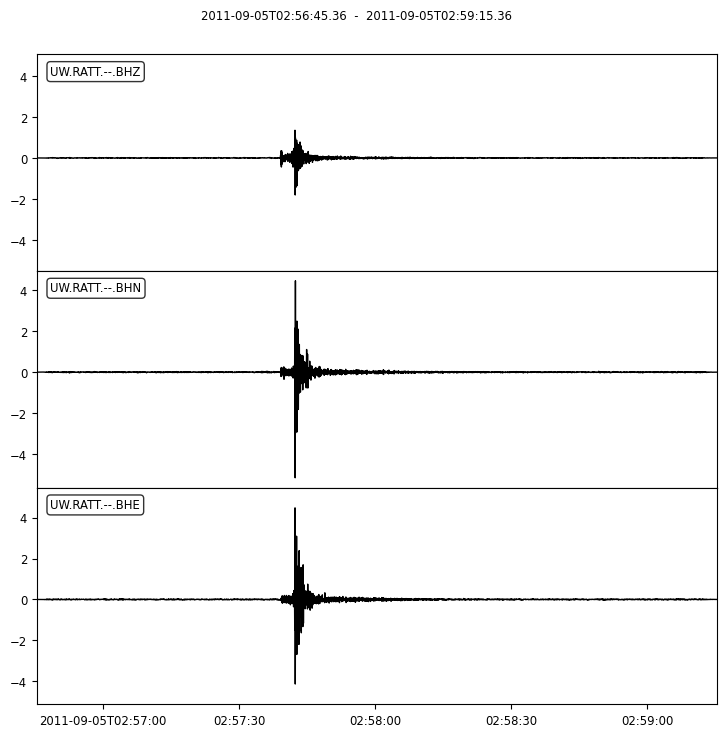

predicted magnitude 2.262843537676996  correct magnitude 1.33
['12.516', '17.195', '6.549']
19
19 3 15001


/home/simonhans/anaconda3/envs/seismo/lib/python3.10/site-packages/obspy/imaging/util.py:266: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small')
/home/simonhans/anaconda3/envs/seismo/lib/python3.10/site-packages/obspy/imaging/waveform.py:815: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small',


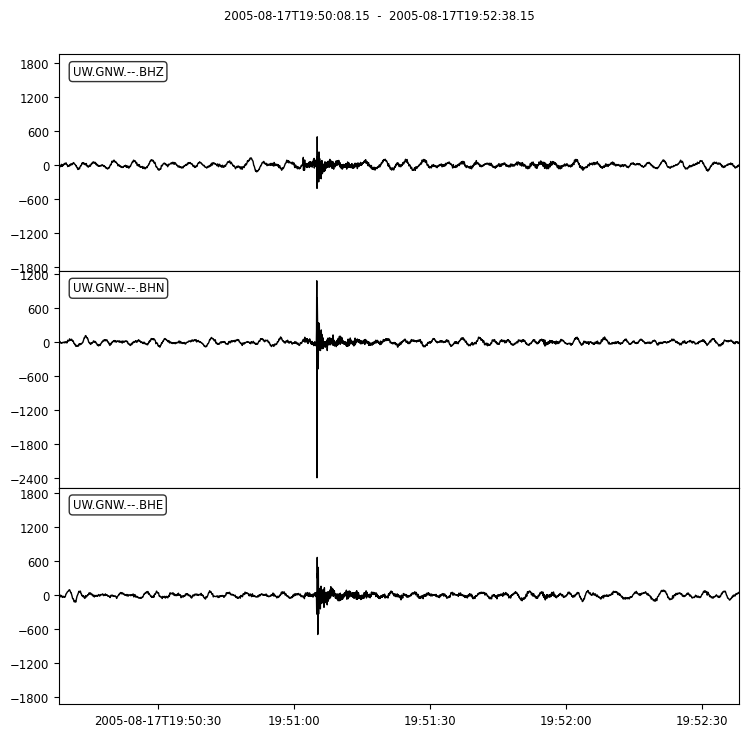

/home/simonhans/anaconda3/envs/seismo/lib/python3.10/site-packages/obspy/imaging/util.py:266: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small')
/home/simonhans/anaconda3/envs/seismo/lib/python3.10/site-packages/obspy/imaging/waveform.py:815: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small',


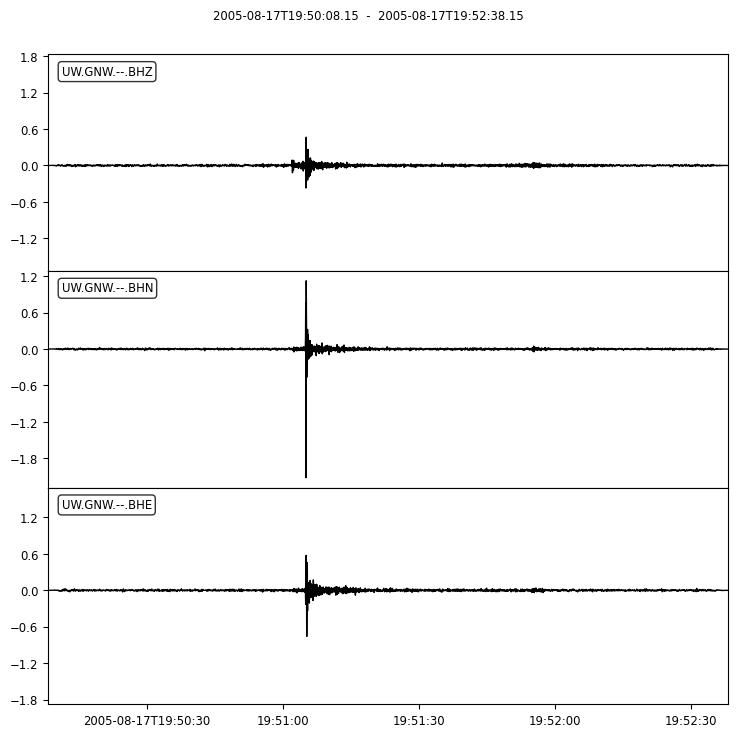

predicted magnitude 1.8784334125164799  correct magnitude 0.8
['10.521', '-0.717', '0.757']
20
20 3 15001


/home/simonhans/anaconda3/envs/seismo/lib/python3.10/site-packages/obspy/imaging/util.py:266: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small')
/home/simonhans/anaconda3/envs/seismo/lib/python3.10/site-packages/obspy/imaging/waveform.py:815: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small',


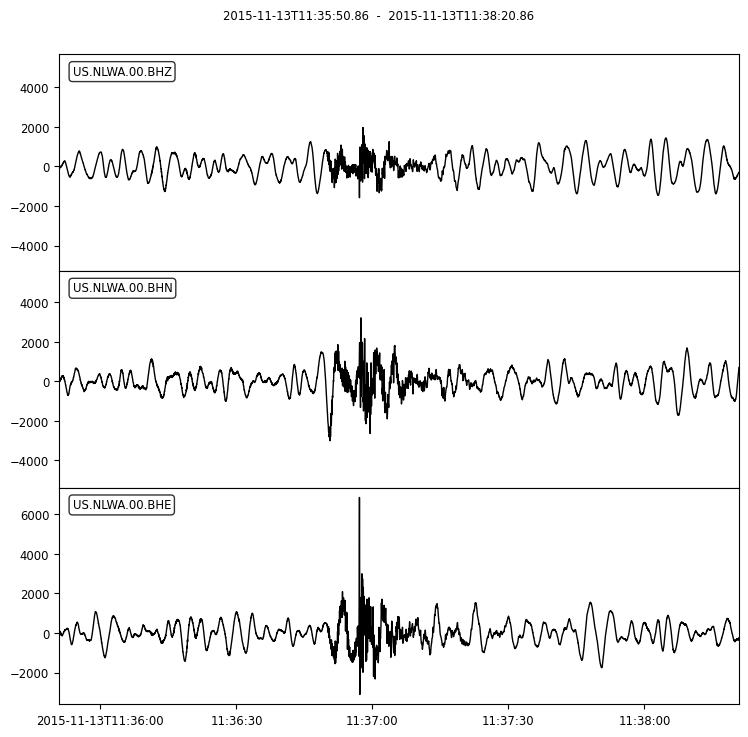

/home/simonhans/anaconda3/envs/seismo/lib/python3.10/site-packages/obspy/imaging/util.py:266: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small')
/home/simonhans/anaconda3/envs/seismo/lib/python3.10/site-packages/obspy/imaging/waveform.py:815: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small',


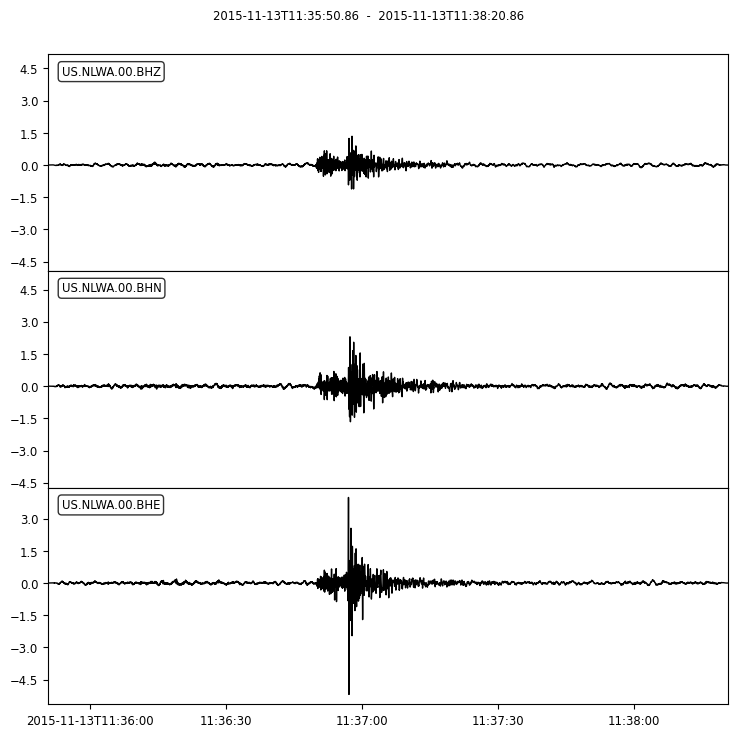

predicted magnitude 3.0433868411234437  correct magnitude 2.69
['-0.341', '1.869', '-4.881']
21
21 3 15001


/home/simonhans/anaconda3/envs/seismo/lib/python3.10/site-packages/obspy/imaging/util.py:266: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small')
/home/simonhans/anaconda3/envs/seismo/lib/python3.10/site-packages/obspy/imaging/waveform.py:815: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small',


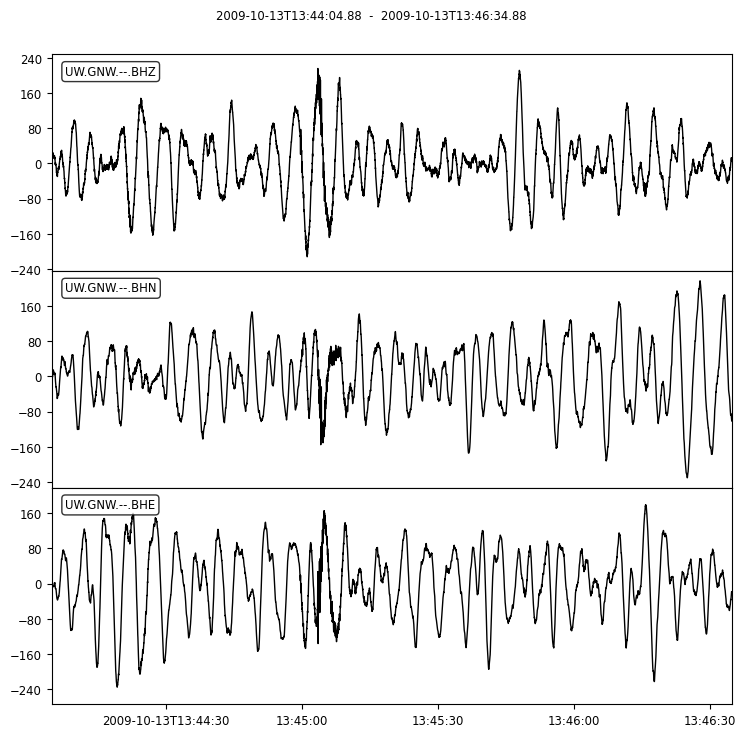

/home/simonhans/anaconda3/envs/seismo/lib/python3.10/site-packages/obspy/imaging/util.py:266: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small')
/home/simonhans/anaconda3/envs/seismo/lib/python3.10/site-packages/obspy/imaging/waveform.py:815: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small',


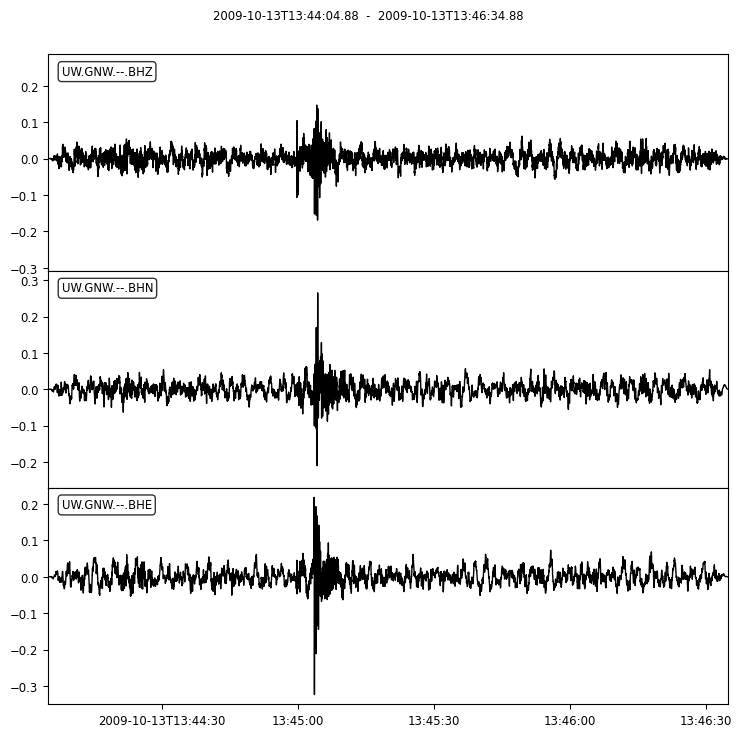

predicted magnitude 1.5484237692510354  correct magnitude 0.97
['6.792', '9.711', '5.028']
22
22 3 15001


/home/simonhans/anaconda3/envs/seismo/lib/python3.10/site-packages/obspy/core/inventory/response.py:1935: UserWarning: More than one PolesZerosResponseStage encountered. Returning first one found.
  warnings.warn(msg)
/home/simonhans/anaconda3/envs/seismo/lib/python3.10/site-packages/obspy/imaging/util.py:266: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small')
/home/simonhans/anaconda3/envs/seismo/lib/python3.10/site-packages/obspy/imaging/waveform.py:815: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small',


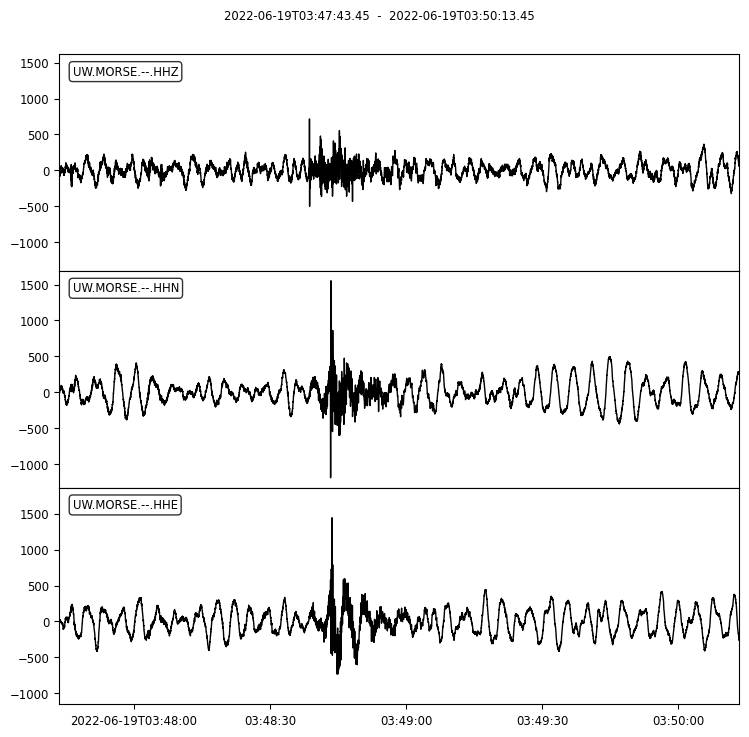

/home/simonhans/anaconda3/envs/seismo/lib/python3.10/site-packages/obspy/imaging/util.py:266: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small')
/home/simonhans/anaconda3/envs/seismo/lib/python3.10/site-packages/obspy/imaging/waveform.py:815: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small',


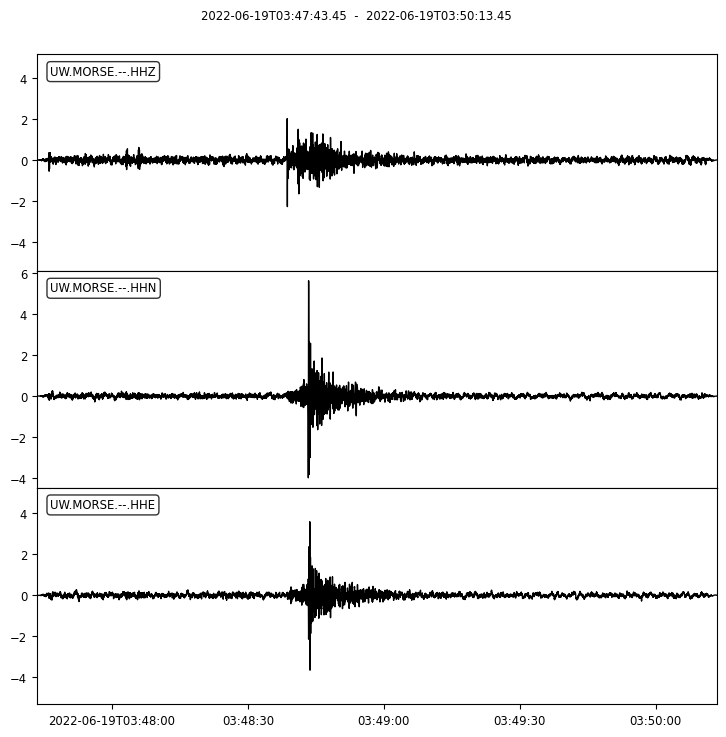

predicted magnitude 2.5263183171695447  correct magnitude 1.46
['-5.751', '-2.919', '2.268']
23
23 3 15001


/home/simonhans/anaconda3/envs/seismo/lib/python3.10/site-packages/obspy/imaging/util.py:266: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small')
/home/simonhans/anaconda3/envs/seismo/lib/python3.10/site-packages/obspy/imaging/waveform.py:815: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small',


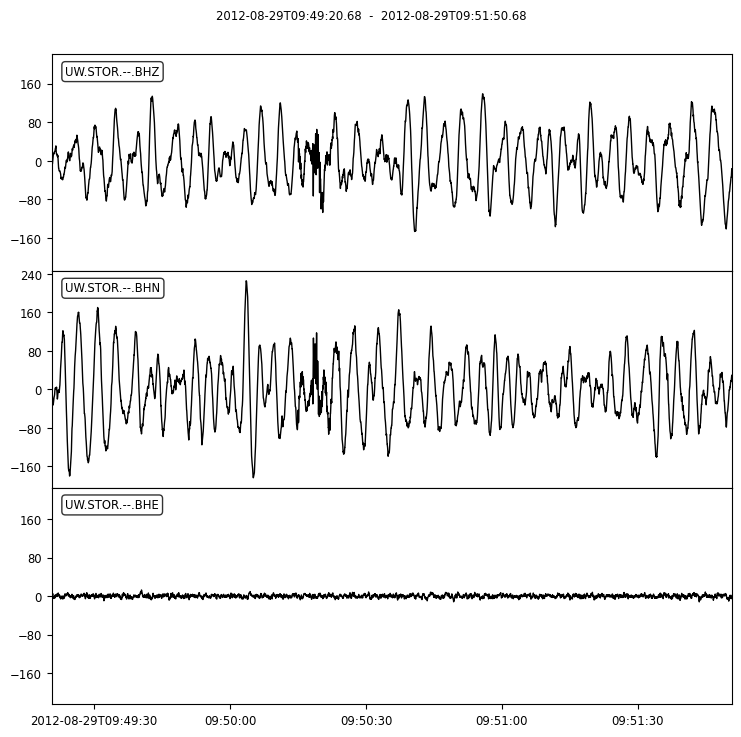

/home/simonhans/anaconda3/envs/seismo/lib/python3.10/site-packages/obspy/imaging/util.py:266: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small')
/home/simonhans/anaconda3/envs/seismo/lib/python3.10/site-packages/obspy/imaging/waveform.py:815: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small',


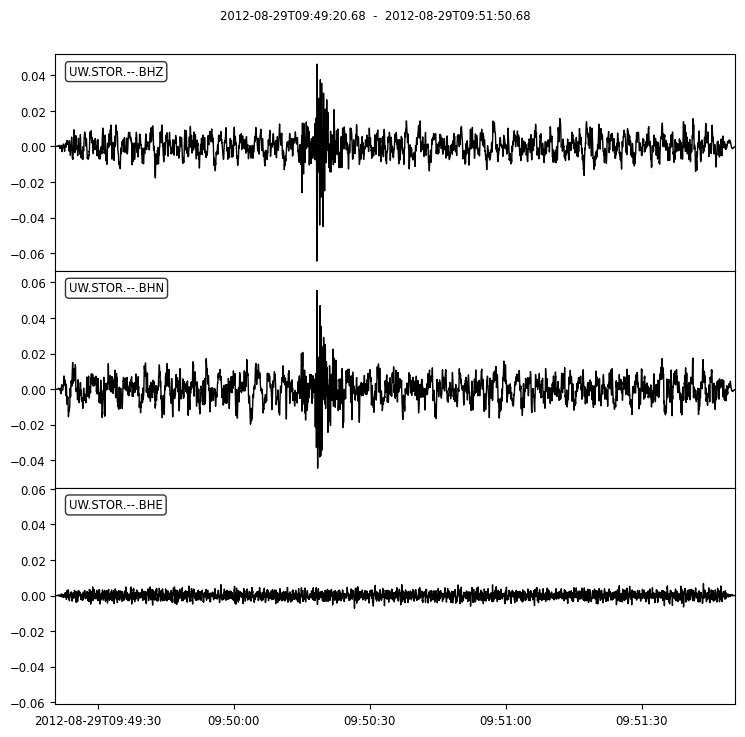

predicted magnitude 0.4764888025697931  correct magnitude 0.64
['-5.43', '-5.489', '-0.059']
24
24 3 15001


/home/simonhans/anaconda3/envs/seismo/lib/python3.10/site-packages/obspy/core/inventory/response.py:1935: UserWarning: More than one PolesZerosResponseStage encountered. Returning first one found.
  warnings.warn(msg)
/home/simonhans/anaconda3/envs/seismo/lib/python3.10/site-packages/obspy/imaging/util.py:266: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small')
/home/simonhans/anaconda3/envs/seismo/lib/python3.10/site-packages/obspy/imaging/waveform.py:815: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small',


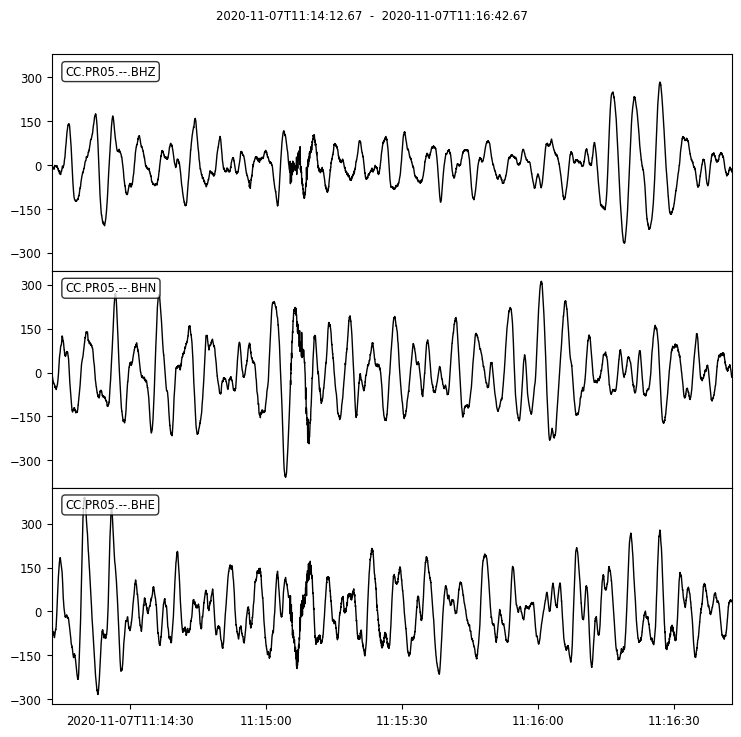

/home/simonhans/anaconda3/envs/seismo/lib/python3.10/site-packages/obspy/imaging/util.py:266: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small')
/home/simonhans/anaconda3/envs/seismo/lib/python3.10/site-packages/obspy/imaging/waveform.py:815: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small',


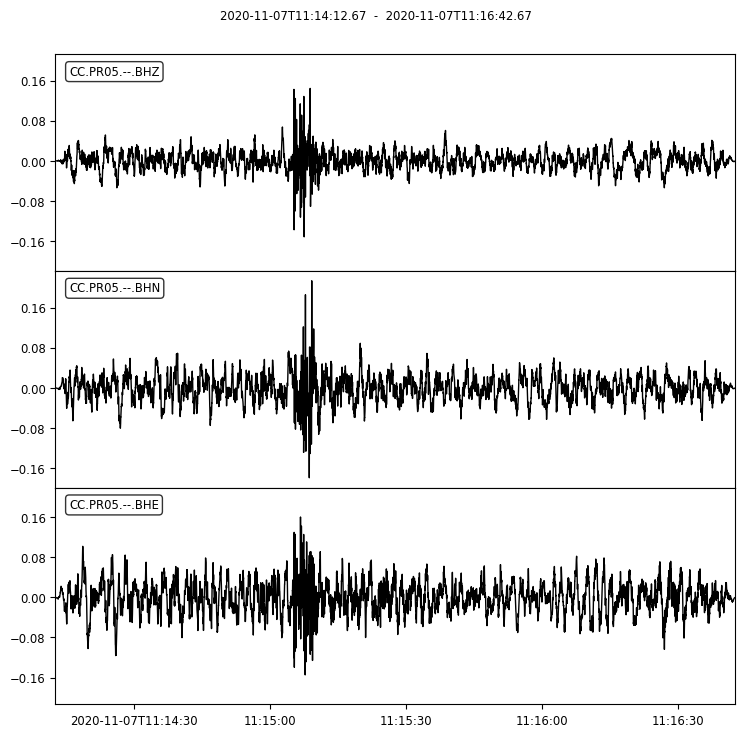

predicted magnitude 1.1312091196303695  correct magnitude 0.49
['10.564', '10.636', '9.445']
25
25 3 15001


/home/simonhans/anaconda3/envs/seismo/lib/python3.10/site-packages/obspy/imaging/util.py:266: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small')
/home/simonhans/anaconda3/envs/seismo/lib/python3.10/site-packages/obspy/imaging/waveform.py:815: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small',


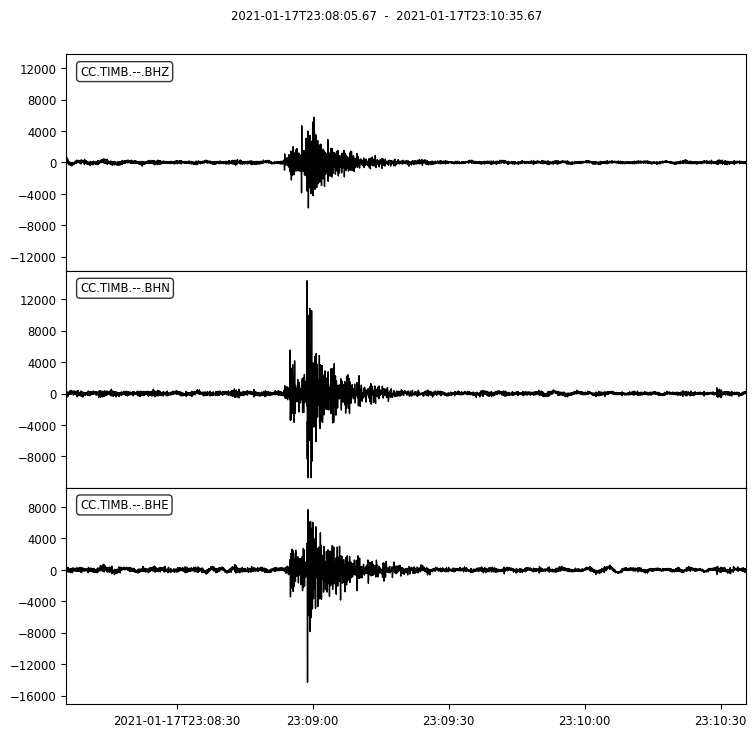

/home/simonhans/anaconda3/envs/seismo/lib/python3.10/site-packages/obspy/imaging/util.py:266: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small')
/home/simonhans/anaconda3/envs/seismo/lib/python3.10/site-packages/obspy/imaging/waveform.py:815: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small',


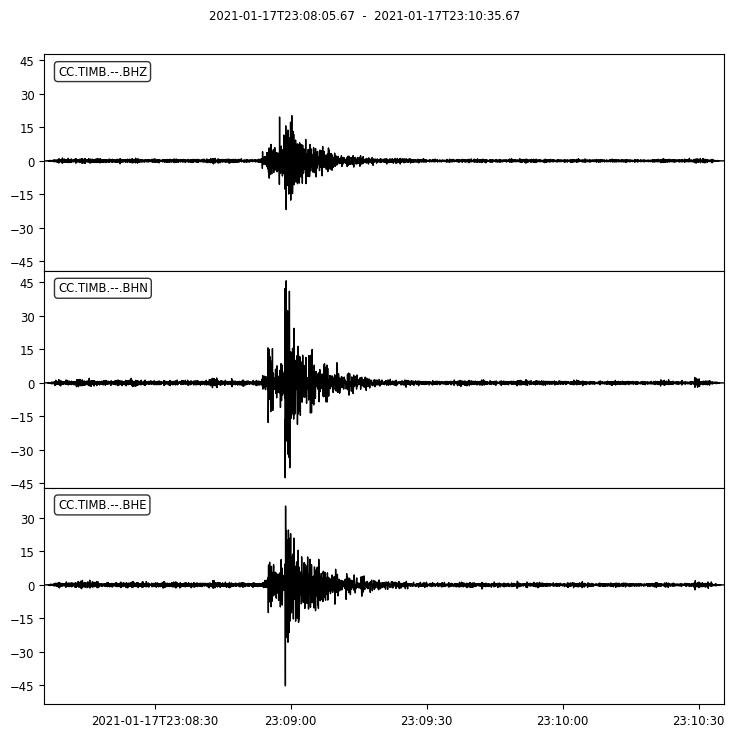

predicted magnitude 3.0575215913354366  correct magnitude 1.79
['5.743', '7.01', '-1.603']
26
26 3 15001


/home/simonhans/anaconda3/envs/seismo/lib/python3.10/site-packages/obspy/imaging/util.py:266: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small')
/home/simonhans/anaconda3/envs/seismo/lib/python3.10/site-packages/obspy/imaging/waveform.py:815: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small',


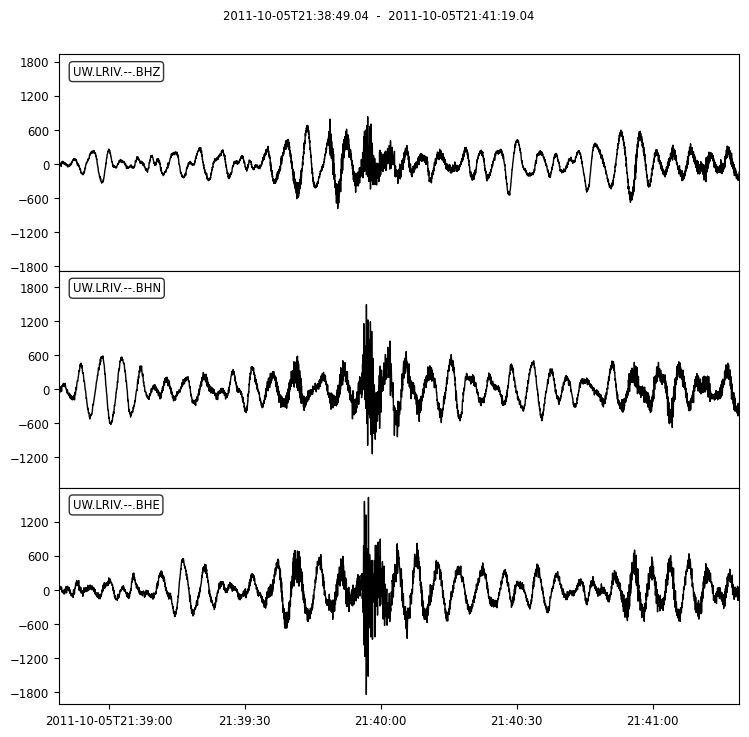

/home/simonhans/anaconda3/envs/seismo/lib/python3.10/site-packages/obspy/imaging/util.py:266: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small')
/home/simonhans/anaconda3/envs/seismo/lib/python3.10/site-packages/obspy/imaging/waveform.py:815: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small',


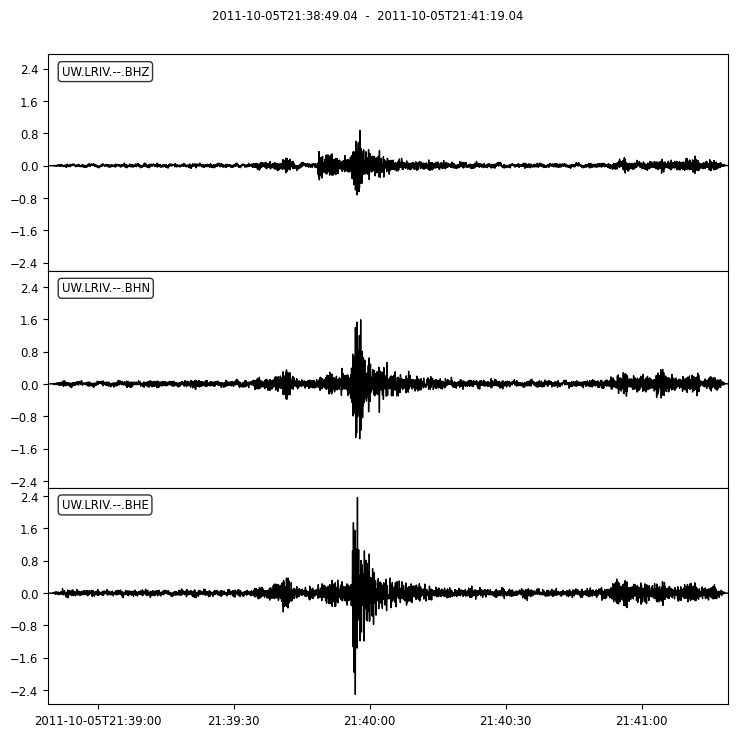

predicted magnitude 2.650938181486884  correct magnitude 1.97
['-1.631', '2.4', '-0.116']
27
27 3 15001


/home/simonhans/anaconda3/envs/seismo/lib/python3.10/site-packages/obspy/core/inventory/response.py:1935: UserWarning: More than one PolesZerosResponseStage encountered. Returning first one found.
  warnings.warn(msg)
/home/simonhans/anaconda3/envs/seismo/lib/python3.10/site-packages/obspy/imaging/util.py:266: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small')
/home/simonhans/anaconda3/envs/seismo/lib/python3.10/site-packages/obspy/imaging/waveform.py:815: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small',


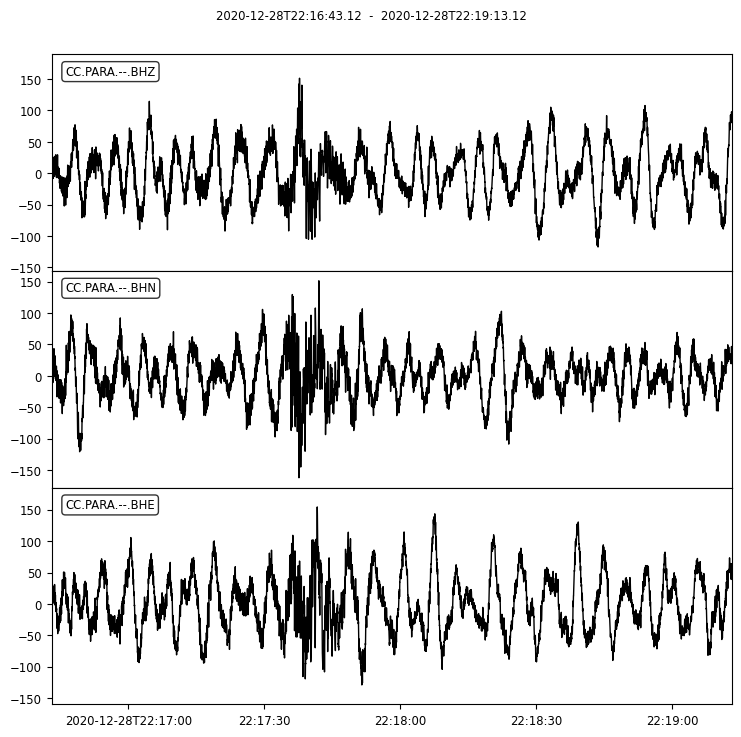

/home/simonhans/anaconda3/envs/seismo/lib/python3.10/site-packages/obspy/imaging/util.py:266: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small')
/home/simonhans/anaconda3/envs/seismo/lib/python3.10/site-packages/obspy/imaging/waveform.py:815: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small',


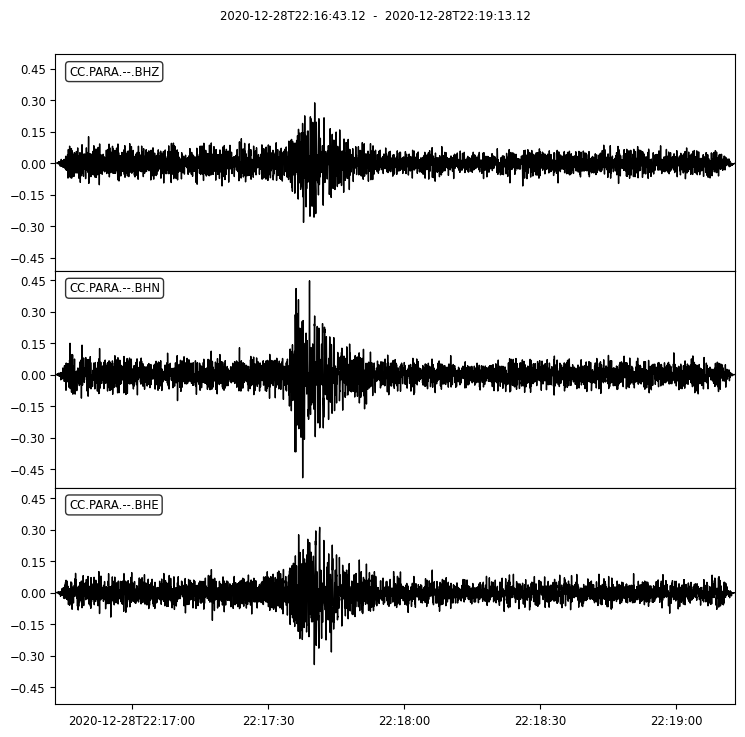

predicted magnitude 1.339465188610322  correct magnitude 0.3
['11.207', '17.077', '14.455']
28
28 3 15001


/home/simonhans/anaconda3/envs/seismo/lib/python3.10/site-packages/obspy/imaging/util.py:266: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small')
/home/simonhans/anaconda3/envs/seismo/lib/python3.10/site-packages/obspy/imaging/waveform.py:815: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small',


In [ ]:
# let's select a station
# import time as time
ml_true=np.zeros(500)
ml_pred=np.zeros(500)
for i in range(500):
  crap=df.iloc[i]["trace_snr_db"].split("|")
  print(crap)
  # if np.min(np.array(crap).astype(np.float))<=20: continue
  print(i)
# try:
  # get the data
  tr,tp,ts,dist=read_data(df, i )


# filter 0.2-50Hz
  tr.filter('highpass',freq=0.2)
  
  # trim data
  tr.trim(starttime=tr[0].stats.starttime+tp-2-120,endtime=tr[0].stats.starttime+tp+100)


  # remove the instrumental zone and convolve with wood anderson
  station=df.iloc[i]["station_code"]
  if df.iloc[i]["station_location_code"]=="--":
    thissta=df.iloc[i]["station_network_code"]+"."+df.iloc[i]["station_code"]+".."+df.iloc[i]["station_channel_code"]+"Z"
  else:
    thissta=df.iloc[i]["station_network_code"]+"."+df.iloc[i]["station_code"]+"."+df.iloc[i]["station_location_code"]+"."+df.iloc[i]["station_channel_code"]+"Z"

  inv0=client.get_stations(network=df.iloc[i]["station_network_code"],station=df.iloc[i]["station_code"],\
                            location="*",channel=df.iloc[i]["station_channel_code"]+"*",\
                        starttime=UTCDateTime(2002,1,1),endtime=UTCDateTime(2022,12,1),level="response")
  datetime1 = UTCDateTime(tr[0].stats.starttime)
  PAZ=inv0.get_response(thissta,datetime1).get_paz()
  paz_sta = {'gain': PAZ.stage_gain,
              'poles': PAZ.poles,
              'sensitivity': PAZ.normalization_factor*PAZ.stage_gain,
              'zeros': PAZ.zeros}
  tr2=tr.copy()
  tr2.simulate(paz_remove=paz_sta, paz_simulate=paz_wood, water_level=10)
  tr.plot()
  tr2.plot()


  ik=np.argmin(np.abs(A0['dist'].values-dist))
  # calculate magnitudes
  E,N,Z=tr2[0].data,tr2[1].data,tr2[2].data
  maxAmp=np.mean( [np.max(np.abs(E)),np.max(np.abs(N)) ])
  ml = np.log10(maxAmp) + A0.iloc[ik,1]

  print("predicted magnitude", ml," correct magnitude",df.iloc[i]["preferred_source_magnitude"])

  ml_true[i]=df.iloc[i]["preferred_source_magnitude"]
  ml_pred[i]=ml
  # time.sleep(1)



    # station=df.iloc[i]["source_magnitude"]

  # except:
    # pass


In [ ]:
plt.plot(ml_true,ml_pred,'o');plt.axis('equal');plt.grid(True);plt.xlabel('True Ml');plt.ylabel('Predicted Ml')

Find the distance and the distance correction for the local magnitude estimate

## BONUS: Duration Magnitude

Let's now compare with a coda duration magnitude. First, we will plot the data in log(amp) to see noise levels and coda amplitude decay.


We will follow a similar process that the University of Utah to calculate the duration magnitude (Koper et al., 2021) and some of the notes from the PNSN process.

The workflow to measure duration may be as follow:

1. Select all vertical seismograms all channels
2. remove instrumental response to ground velocity in m/s
3. filter the data wth a 4th pole butterworth bandpass between 1 and 10 Hz.
4. take the envelope of the seismograms ($\sqrt{ x^2(t) + H(x(t))^2}$)
5. take the $log_{10}$ of the envelope.
6. $t_P$ is the P-wave arrival time.
7. $t_S$ is the S-wave arrival time.
7. $t_{peak}$ is the time of maximum amplitude after the S.
12. the noise is the average value of the envelope in a 10 s window starting 12 s before the theoretical P-wave arrival time (tP).
13. the duration $T_D = t_3-t_{peak}$ 
14. calculate the moment duration using the equation: $M_D = -1.61 + 2.82*log10(T_D)$ , where $\Delta$ is the source receiver distance. $M_d$ is taken as the median of at least 3 station-estimates.


In [ ]:
# let's select a station
# import time as time
md_true=np.zeros(500)
md_pred=np.zeros(500)
for i in range(500):
  tr,tp,ts,dist=read_data(df, i )

  # remove the instrumental zone and convolve with wood anderson
  station=df.iloc[i]["station_code"]
  if df.iloc[i]["station_location_code"]=="--":
    thissta=df.iloc[i]["station_network_code"]+"."+df.iloc[i]["station_code"]+".."+df.iloc[i]["station_channel_code"]+"Z"
  else:
    thissta=df.iloc[i]["station_network_code"]+"."+df.iloc[i]["station_code"]+"."+df.iloc[i]["station_location_code"]+"."+df.iloc[i]["station_channel_code"]+"Z"

  inv0=client.get_stations(network=df.iloc[i]["station_network_code"],station=df.iloc[i]["station_code"],\
                            location="*",channel=df.iloc[i]["station_channel_code"]+"*",\
                        starttime=UTCDateTime(2002,1,1),endtime=UTCDateTime(2022,12,1),level="response")
  # remove response
  PAZ=inv0.get_response(thissta,tr[0].stats.starttime).get_paz()
  paz_sta = {'gain': PAZ.stage_gain,
              'poles': PAZ.poles,
              'sensitivity': PAZ.normalization_factor*PAZ.stage_gain,
              'zeros': PAZ.zeros}
  tr.simulate(paz_remove=paz_sta, water_level=10)
  # filter 1-10Hz
  tr.filter('bandpass',freqmin=1,freqmax=10,corners=2,zerophase=True)
  # calculate envelope using the obspy function of the vertical component, and then its log
  data_envelope = np.log10(obspy.signal.filter.envelope(tr[2].data))
  tr2=tr[2].copy()
  tr2.data[:]=data_envelope

  # calculate the time at which the envelope hits 2 times the noise floor
  noise = tr2.copy()
  noise.trim(tp-12,tp-2)
  nnoise_value = np.mean(noise[0].data)
  fig=plt.figure()
  plt.plot(tr2.data)


  # time of pick

  wave=tr2.copy()
  wave=tr2.trim(tr2.stats.starttime+tp,tr2.stats.starttime+tp+ts+30)

  # get the first element of the time series where the envelope is 

  plt.plot(tr2.data-np.log10(2*10**nnoise_value),'r');plt.grid(True)
  # print(nnoise_value,tr.stats,len(wave[0].data))
  print(len(wave.data[wave.data>=np.log10(2*10**nnoise_value)]))
  Td = len(wave.data[wave.data>=np.log10(2*10**nnoise_value)])/tr2.stats.sampling_rate #duration
  print("duration",str(Td))
  md_pred[i] = -1.61+2.82*np.log10(Td)
  md_true[i]=df.iloc[i]["source_duration_magnitude"]

  print("predicted magnitude", md_pred[i]," correct magnitude",df.iloc[i]["source_duration_magnitude"])
  

In [ ]:
plt.plot(md_true,md_predicted,'o')